## Loading the libraries and the data

In [1]:
import os
import numpy as np 
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 300, "savefig.dpi": 300}) # I like high-res figures 
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
import seaborn as sns
import umap
from matplotlib.lines import Line2D
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
from scipy.spatial.distance import cdist, pdist
from scipy.stats import wasserstein_distance
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, accuracy_score
)

In [2]:
E_base        = np.load("/Users/ali/Downloads/emb_base_5k (1).npy")
E_c9_als_up   = np.load("/Users/ali/Downloads/emb_C9orf72_ALS_up_5k.npy")
E_k5_als_down = np.load("KIF5A_perturb_ALS_down.npy")
E_multiple_down = np.load("multiple_perturb_ALS_down.npy")

#------------------------------------------------------------------------

base               = ad.read_h5ad("adata_base_5k.h5ad")
C9orf72_als_up     = ad.read_h5ad("adata_C9orf72_ALS_up_5k.h5ad")
KIF5A_als_down    = ad.read_h5ad("adata_KIF5A_perturb_ALS_down.h5ad")
multiple_als_down  = ad.read_h5ad("adata_multiple_perturb_ALS_down.h5ad")

## 3.1. PCA plot

Let's run a simple PCA plot on the embeddings to see how they stack up against each other. We will have 4 plots in total, with 2 plots (highlighted by `Condition` to make it easier to see cells in the latent space) per category (baseline or pertubration).

Here's what we are plotting:

- Base
- C9orf72 ↑ (up-regulation)

Here's what the code is doing:
- First we normalize the names to "pn" and "als" in the `Condition column` using the `norm_condition_df` function.
- After that, we use custom function to plot PCA plots `pca_highlight_grid` - it basically creates plots together in a grid for multiple conditions, while highlighting each condition separately, because it's difficult to figure out which embeddings come from which cells when they are overlayed. We can 
    - The `panels` argument takes in  list of three things:
        - The names of the plots. 
        - The embeddings
        - And the cell labels
- Next, we basically generate a PCA plot using the embeddings and color them separately twice - once for `ALS` and once for `PN`, for both the base (non-perturbed) and the _C9orf72_ up-regulated state.

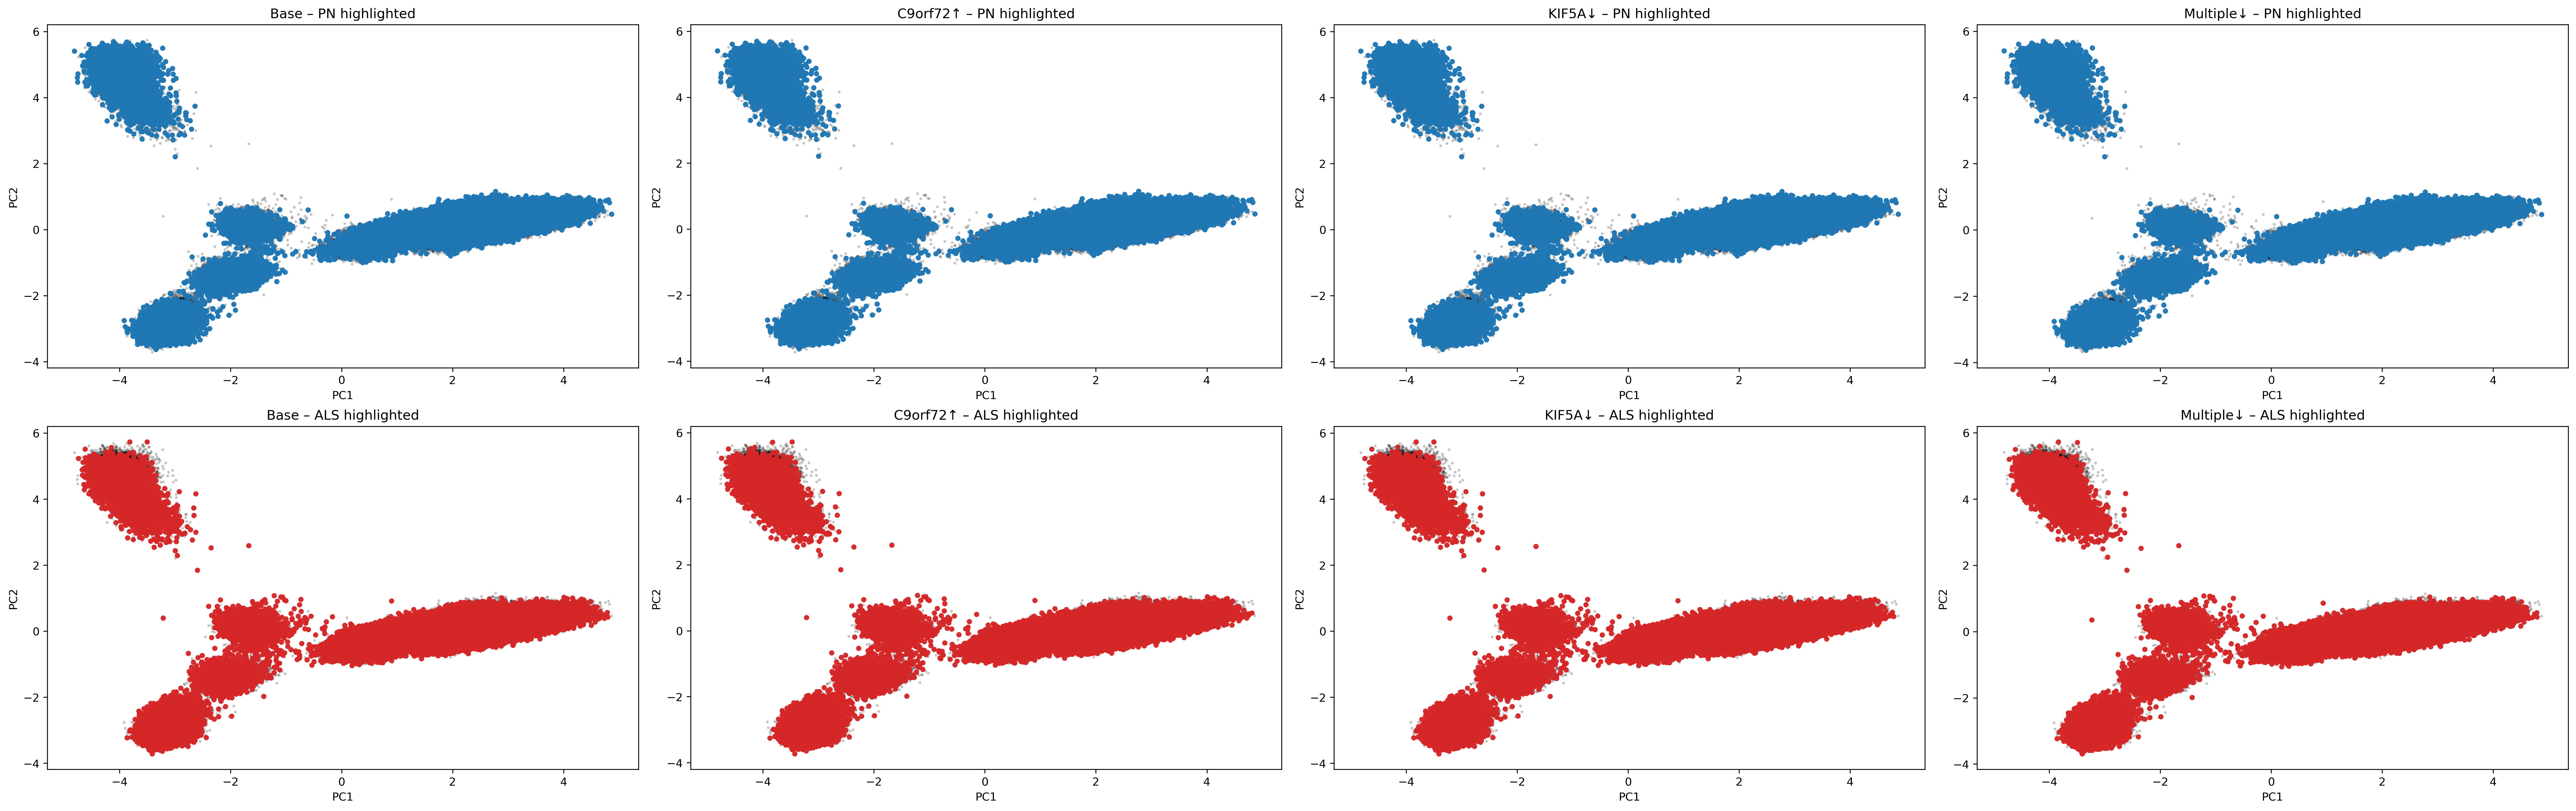

In [3]:
import numpy as np
import scanpy as ad
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

E_base        = np.load("/Users/ali/Downloads/emb_base_5k (1).npy")
E_c9_als_up   = np.load("/Users/ali/Downloads/emb_C9orf72_ALS_up_5k.npy")
E_k5_als_down = np.load("KIF5A_perturb_ALS_down.npy")
E_multiple_down = np.load("multiple_perturb_ALS_down.npy")

base               = ad.read_h5ad("adata_base_5k.h5ad")
C9orf72_als_up     = ad.read_h5ad("adata_C9orf72_ALS_up_5k.h5ad")
KIF5A_als_down     = ad.read_h5ad("adata_KIF5A_perturb_ALS_down.h5ad")
multiple_als_down  = ad.read_h5ad("adata_multiple_perturb_ALS_down.h5ad")

def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np": "pn", "control": "pn"})

def pca_highlight_grid(panels, outfile="pca_4panels_2x2.png", rs=0, figsize_per_panel=(7, 10), dpi=600, s_bg=4, s_hi=12):
    n = len(panels)
    fig_w = figsize_per_panel[0] * n
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(2, n, figsize=(fig_w, fig_h), constrained_layout=True)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    for i, (name, E, lab) in enumerate(panels):
        if E.shape[0] != len(lab):
            raise ValueError(f"{name}: embeddings rows ({E.shape[0]}) != labels length ({len(lab)})")
        P = PCA(n_components=2, random_state=rs).fit_transform(E)
        m_als = (lab.values == "als")
        m_pn  = (lab.values == "pn")
        ax = axes[0, i]
        ax.scatter(P[:,0], P[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(P[m_pn,0], P[m_pn,1], s=s_hi, c="#1f77b4", alpha=0.95, label="PN", rasterized=True)
        ax.set_title(f"{name} – PN highlighted")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
        ax = axes[1, i]
        ax.scatter(P[:,0], P[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(P[m_als,0], P[m_als,1], s=s_hi, c="#d62728", alpha=0.95, label="ALS", rasterized=True)
        ax.set_title(f"{name} – ALS highlighted")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    plt.savefig(outfile, dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.savefig(outfile.replace(".png", ".pdf"), bbox_inches="tight", facecolor="white")
    plt.show()

labels_base      = norm_condition_df(base.obs)
labels_c9_up     = norm_condition_df(C9orf72_als_up.obs)
labels_kif5a_dn  = norm_condition_df(KIF5A_als_down.obs)
labels_multi_dn  = norm_condition_df(multiple_als_down.obs)

panels = [
    ("Base",         E_base,           labels_base),
    ("C9orf72↑",     E_c9_als_up,      labels_c9_up),
    ("KIF5A↓",       E_k5_als_down,    labels_kif5a_dn),
    ("Multiple↓",    E_multiple_down,  labels_multi_dn),
]

pca_highlight_grid(
    panels,
    outfile="pca_4panels_2x2.png",
    rs=0,
    figsize_per_panel=(8, 10),
    dpi=300,
    s_bg=3, s_hi=14
)

**Figure 1**: On the PCA plot, there doesn't seem to be a drastic visual difference between the baseline or any of the perturbations. We can probe it further using the more non-linear UMAPs. 

## 3.2. UMAP

The code for producing UMAPs is pretty much re-used from the PCA plotting so it functionally works exactly the same, except that now we are generating a UMAP instead of running a PCA. So the arguments are essentially the same, but the name of the function differs a little. 

### 3.2.1. UMAP by Condition

In this first UMAP, we are going to plot the embeddings and color them by condition: `ALS` and `PN`. 

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


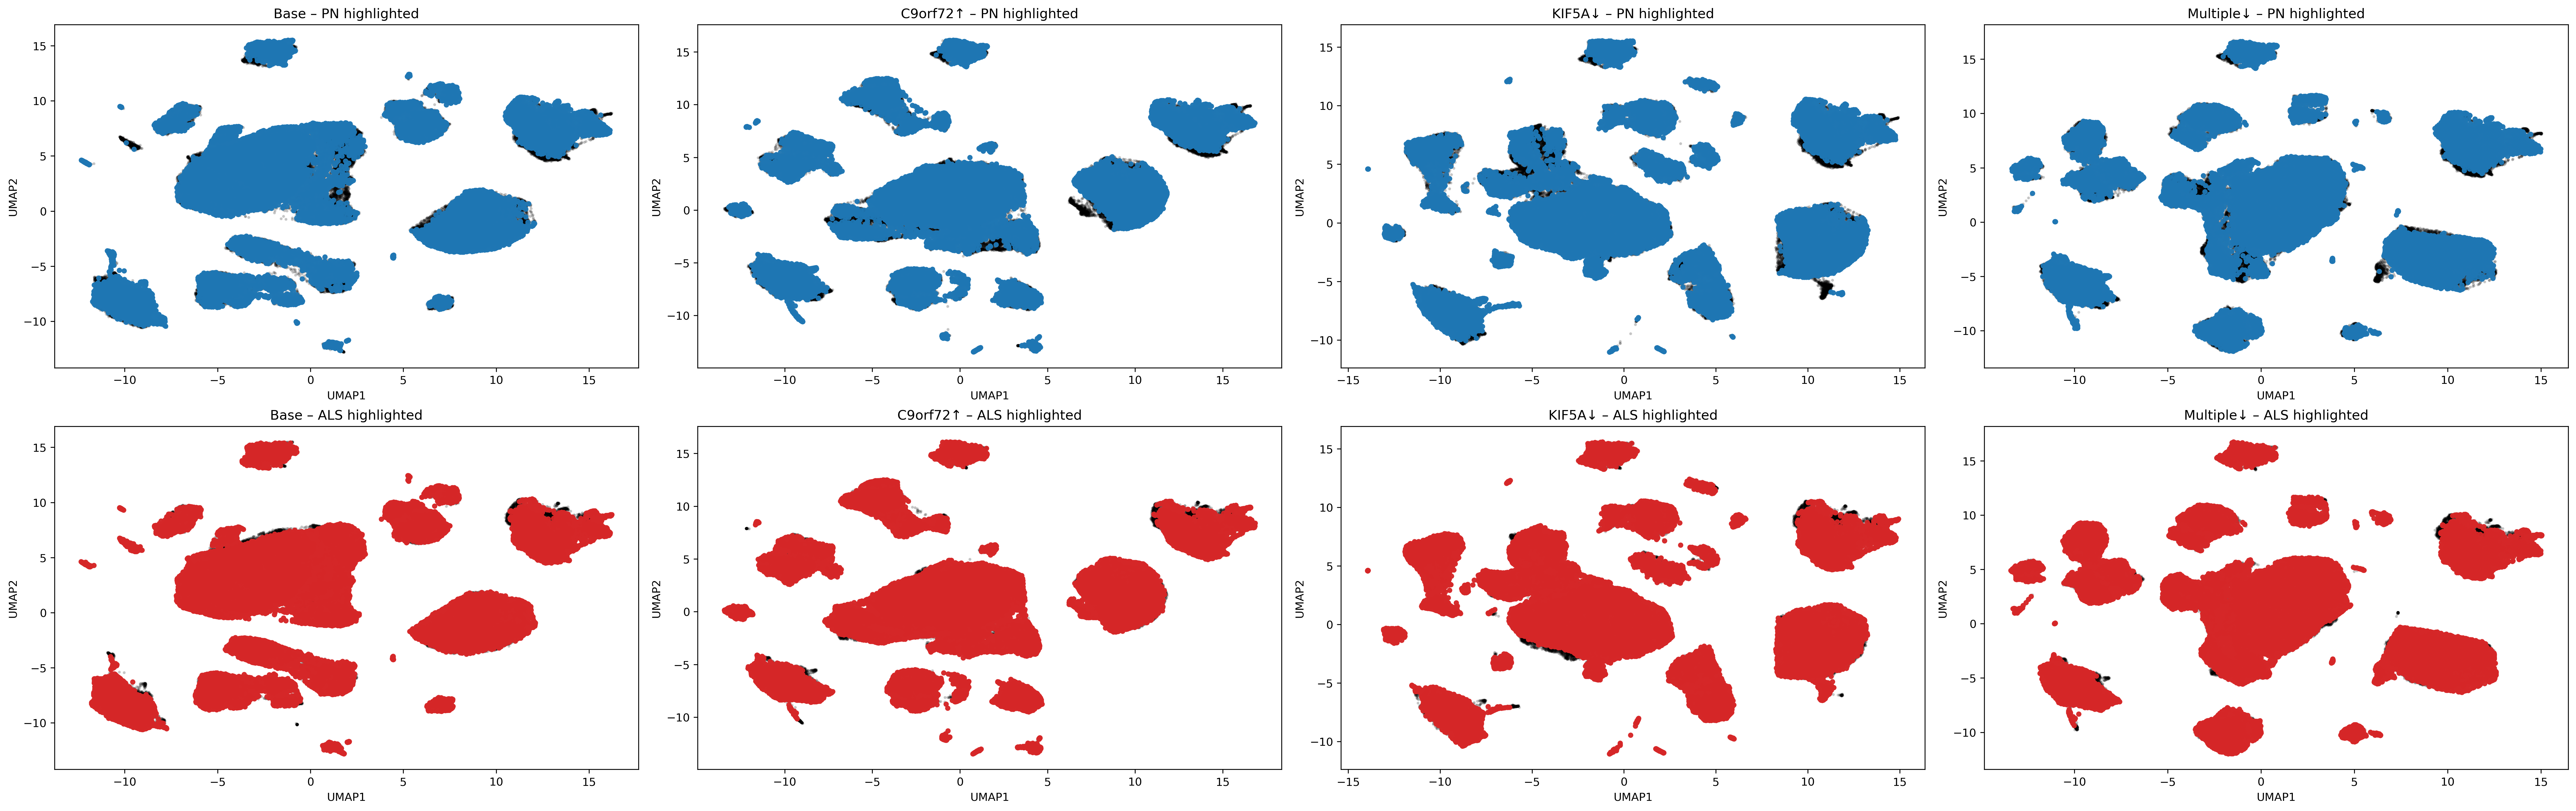

In [4]:
import numpy as np
import scanpy as ad
import pandas as pd
import umap
import matplotlib.pyplot as plt

E_base          = np.load("/Users/ali/Downloads/emb_base_5k (1).npy")
E_c9_als_up     = np.load("/Users/ali/Downloads/emb_C9orf72_ALS_up_5k.npy")
E_k5_als_down   = np.load("KIF5A_perturb_ALS_down.npy")
E_multiple_down = np.load("multiple_perturb_ALS_down.npy")

base               = ad.read_h5ad("adata_base_5k.h5ad")
C9orf72_als_up     = ad.read_h5ad("adata_C9orf72_ALS_up_5k.h5ad")
KIF5A_als_down     = ad.read_h5ad("adata_KIF5A_perturb_ALS_down.h5ad")
multiple_als_down  = ad.read_h5ad("adata_multiple_perturb_ALS_down.h5ad")

def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np": "pn", "control": "pn"})

def umap_highlight_grid(
    panels,
    outfile="umap_4panels_2x2.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize_per_panel=(7, 10),
    dpi=300,
    s_bg=4,
    s_hi=12
):
    n = len(panels)
    fig_w = figsize_per_panel[0] * n
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(2, n, figsize=(fig_w, fig_h), constrained_layout=True)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    for i, (name, E, lab) in enumerate(panels):
        if E.shape[0] != len(lab):
            raise ValueError(f"{name}: embeddings rows ({E.shape[0]}) != labels length ({len(lab)})")
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=rs)
        U = reducer.fit_transform(E)
        m_als = (lab.values == "als")
        m_pn  = (lab.values == "pn")
        ax = axes[0, i]
        ax.scatter(U[:,0], U[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(U[m_pn,0], U[m_pn,1], s=s_hi, c="#1f77b4", alpha=0.95, label="PN", rasterized=True)
        ax.set_title(f"{name} – PN highlighted")
        ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
        ax = axes[1, i]
        ax.scatter(U[:,0], U[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(U[m_als,0], U[m_als,1], s=s_hi, c="#d62728", alpha=0.95, label="ALS", rasterized=True)
        ax.set_title(f"{name} – ALS highlighted")
        ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
    plt.savefig(outfile, dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.savefig(outfile.replace(".png", ".pdf"), bbox_inches="tight", facecolor="white")
    plt.show()

labels_base      = norm_condition_df(base.obs)
labels_c9_up     = norm_condition_df(C9orf72_als_up.obs)
labels_kif5a_dn  = norm_condition_df(KIF5A_als_down.obs)
labels_multi_dn  = norm_condition_df(multiple_als_down.obs)

panels = [
    ("Base",         E_base,           labels_base),
    ("C9orf72↑",     E_c9_als_up,      labels_c9_up),
    ("KIF5A↓",       E_k5_als_down,    labels_kif5a_dn),
    ("Multiple↓",    E_multiple_down,  labels_multi_dn),
]

umap_highlight_grid(
    panels,
    outfile="umap_4panels_2x2.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize_per_panel=(8, 10),
    dpi=300,
    s_bg=3,
    s_hi=14
)

**Figure 2A**: For the UMAPs, we can see that there seems to be some difference in the embeddings and their positions in the latent space, in response to the perturbations. This gives us that biological signal that we want to track. However, we need to probe it further to see where the signal is originating from. 

### 3.2.2. UMAP by Cell Types

For this UMAP, we will plot the embeddings and color them by the cell types they belong to. Here's what's going on:

- The `get_celltype_series` function takes the `CellType` column and converts it to string and replaces NAs with "Unknown" cell types - a little sanity check that also handles missing values. 
- The `build_type_palette` function essentially assigns a unique color to each cell type so that we can visualize them distinctly. 
- And the `umap_celltype_grid_two` is basically the UMAP plotting function from above with additional modifications to account for coloring by cell types.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


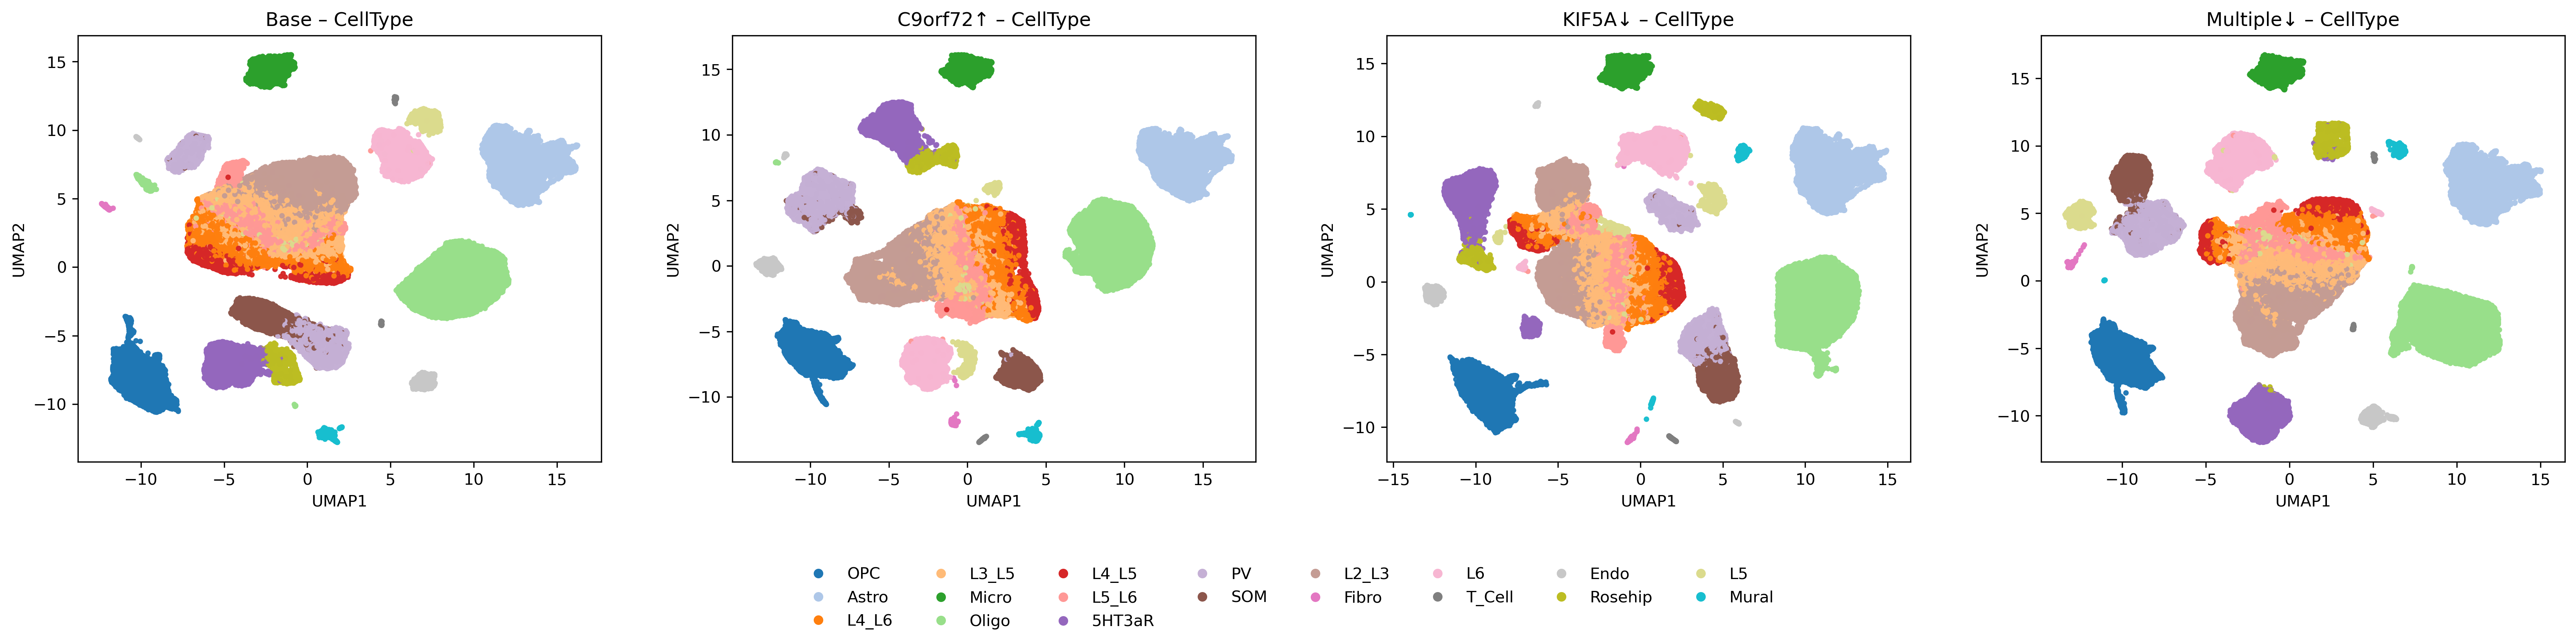

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from matplotlib.lines import Line2D

def get_celltype_series(obs):
    for k in ["CellType"]:
        if k in obs.columns:
            return obs[k].astype(str).fillna("Unknown")
    raise KeyError("No CellType column found (tried: CellType).")

def build_type_palette(all_types):
    cmaps = [plt.colormaps.get_cmap("tab20"),
             plt.colormaps.get_cmap("tab20b"),
             plt.colormaps.get_cmap("tab20c")]
    colors = []
    i = 0
    while len(colors) < len(all_types):
        cmap = cmaps[i % len(cmaps)]
        for j in range(cmap.N):
            colors.append(cmap(j))
            if len(colors) >= len(all_types):
                break
        i += 1
    return {t: colors[k] for k, t in enumerate(all_types)}

def umap_celltype_grid(
    panels,
    outfile="umap_celltype_grid_4panels.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize_per_panel=(7, 6),
    dpi=300,
    s=6
):
    cts_list = [get_celltype_series(a.obs) for _, _, a in panels]
    for (name, E, _), ct in zip(panels, cts_list):
        if E.shape[0] != len(ct):
            raise ValueError(f"{name}: embeddings rows ({E.shape[0]}) != celltype length ({len(ct)})")
    all_types = pd.unique(pd.concat(cts_list, ignore_index=True))
    type_to_color = build_type_palette(all_types)
    n = len(panels)
    fig_w = figsize_per_panel[0] * n
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(1, n, figsize=(fig_w, fig_h), constrained_layout=False)
    if n == 1:
        axes = np.array([axes])
    for ax, (name, E, a), ct in zip(np.ravel(axes), panels, cts_list):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=rs)
        U = reducer.fit_transform(E)
        colors = [type_to_color.get(t, (0.5, 0.5, 0.5, 0.7)) for t in ct.values]
        ax.scatter(U[:, 0], U[:, 1], s=s, c=colors, alpha=0.95, rasterized=True)
        ax.set_title(f"{name} – CellType")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
    handles = [Line2D([0], [0], marker="o", linestyle="None", markersize=6,
                      markerfacecolor=type_to_color[t], markeredgecolor="none", label=t)
               for t in all_types]
    fig.subplots_adjust(bottom=0.26, wspace=0.25)
    fig.legend(handles=handles, loc="lower center", ncol=min(8, len(handles)), frameon=False)
    plt.savefig(outfile, dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.savefig(outfile.replace(".png", ".pdf"), bbox_inches="tight", facecolor="white")
    plt.show()

panels_four = [
    ("Base",         E_base,           base),
    ("C9orf72↑",     E_c9_als_up,      C9orf72_als_up),
    ("KIF5A↓",       E_k5_als_down,    KIF5A_als_down),
    ("Multiple↓",    E_multiple_down,  multiple_als_down),
]

umap_celltype_grid(
    panels_four,
    outfile="umap_celltype_grid_4panels.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize_per_panel=(7, 6),
    dpi=300,
    s=6
)

**Figure 2B**: We can qualitatively see that there are certain diffferences between the base and the perturbed data. Let's summarize them below:
- The `L2_L3` cluster seems to be a little distorted in the _C9orf72_ dataset, compared to the base. The `PV-SOM` cluster also seems to break away into a separate `SOM` cluster in the perturbed dataset. 
- The _KIF5A_ seems to be the most visually disrupted, especially in the giant central cluster. 
- Multiple perturbations also seem to affect the giant central cluster and the `PV-SOM` cluster. 

Besides these changes, the rest of the shifts in the latent space are hard to qualitatively analyze. So we will move to more quantitative methods to analyze these changes. 

## 3.3. Clustering

In this part, we will try some unsupervised clustering to see how the embeddings group together and if there are any insights that we can pull from that. 

### 3.3.1. Elbow and Silhouette Plots

To determine a good number of K-clusters to use, I ran an elbow plot and a silhouette plot. Additionally, I calculated the distance between a cell and it's 15th nearest neighbor just to see if how the global neighborhoods look like between the two figures, and see if there's some sort of neighborhood distortment in response to the perturbations. 

- The `knn_distance_elbow` basically fits a NN model using euclidean distance - we can control the number of neighbors by using `n_neighbors`, and we can also subset the data for speed by using a `sample_size` argument.
- The `cluster_elbow_metrics` function essentially fits a KMeans model with different values of _k_ to find the best one. And we also save the inertia and the silhouette scores that we get from this model to evaluate the different values of _k_ at the end. 

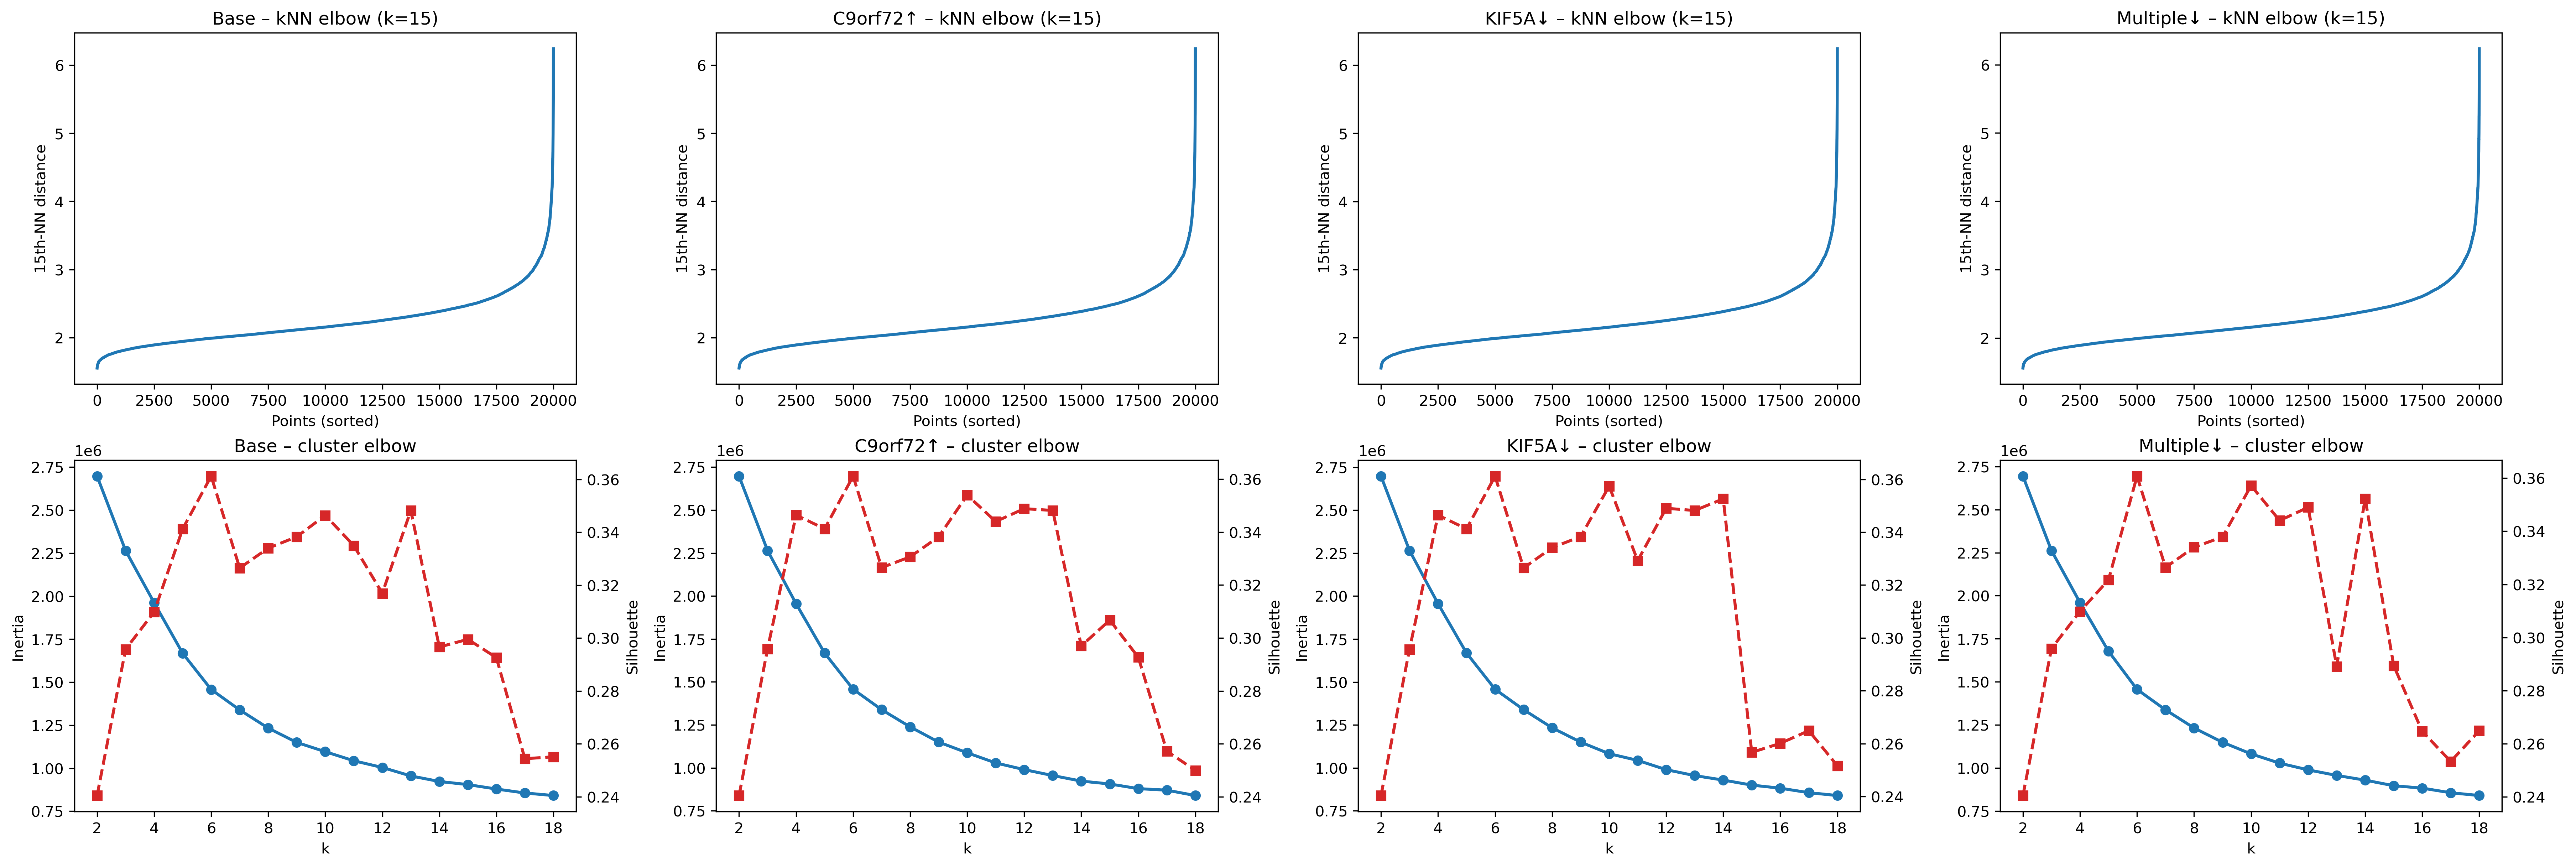

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = np.arange(2, 19)

names  = ["Base", "C9orf72↑", "KIF5A↓", "Multiple↓"]
embeds = [E_base, E_c9_als_up, E_k5_als_down, E_multiple_down]

def knn_distance_elbow(X, n_neighbors=15, sample_size=20000, rs=0):
    rng = np.random.default_rng(rs)
    if X.shape[0] > sample_size:
        idx = rng.choice(X.shape[0], size=sample_size, replace=False)
        X_use = X[idx]
    else:
        X_use = X
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X_use)
    dists, _ = nn.kneighbors(X_use)
    kth = dists[:, n_neighbors-1]
    return np.sort(kth)

def cluster_elbow_metrics(X, ks, sample_size_sil=3000, rs=0):
    rng = np.random.default_rng(rs)
    inertias, sils = [], []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=rs).fit(X)
        inertias.append(km.inertia_)
        if X.shape[0] > sample_size_sil:
            idx = rng.choice(X.shape[0], size=sample_size_sil, replace=False)
            sil = silhouette_score(X[idx], km.predict(X[idx]), metric="euclidean")
        else:
            sil = silhouette_score(X, km.labels_, metric="euclidean")
        sils.append(sil)
    return np.array(inertias), np.array(sils)

def plot_elbows(names, embeds, ks, outfile="elbows_4panels.png", rs=0, figsize_per_panel=(6, 4)):
    n = len(embeds)
    fig_w = figsize_per_panel[0] * n
    fig_h = figsize_per_panel[1] * 2
    fig, axes = plt.subplots(2, n, figsize=(fig_w, fig_h), constrained_layout=True)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    for i, (name, E) in enumerate(zip(names, embeds)):
        elbow = knn_distance_elbow(E, n_neighbors=15, sample_size=20000, rs=rs)
        ax = axes[0, i]
        ax.plot(np.arange(len(elbow)), elbow, lw=2)
        ax.set_title(f"{name} – kNN elbow (k=15)")
        ax.set_xlabel("Points (sorted)")
        ax.set_ylabel("15th-NN distance")
    for i, (name, E) in enumerate(zip(names, embeds)):
        inertias, sils = cluster_elbow_metrics(E, ks, sample_size_sil=3000, rs=rs)
        ax1 = axes[1, i]
        ax2 = ax1.twinx()
        ax1.plot(ks, inertias, marker="o", lw=2, label="Inertia")
        ax2.plot(ks, sils, marker="s", lw=2, ls="--", color="#d62728", label="Silhouette")
        ax1.set_title(f"{name} – cluster elbow")
        ax1.set_xlabel("k")
        ax1.set_ylabel("Inertia")
        ax2.set_ylabel("Silhouette")
    plt.savefig(outfile, dpi=300, bbox_inches="tight", facecolor="white")
    plt.savefig(outfile.replace(".png", ".pdf"), bbox_inches="tight", facecolor="white")
    plt.show()

plot_elbows(names, embeds, ks, outfile="elbows_4panels.png", rs=0, figsize_per_panel=(6, 4))

**Figure 3A**: Based on the neighborhood analysis (top row), we can see that the distance between the neighbors is pretty much the same, and the global organization does not differ too much between the base and the perturbed states. Additionally, based on the inertia elbow and the silhouette peak, we can see that the optimal number for `k` is 6 for all experiments. 

### 3.3.2. KMeans Clustering using K = 6

Having figured out the best `k` from our silhouette plot above, we will now proceed to run a KMeans model using the selected `k` and then plot a UMAP colored by clusters to see how the clusters distribute in different conditions. Here's what I am doing in this code chunk:

- Running a KMeans model using the best `k` that we got. 
- Visualize the clusters using a UMAP.
- Find out if the proportions of ALS vs PN cells differs by cluster using a Chi-squared test. 

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


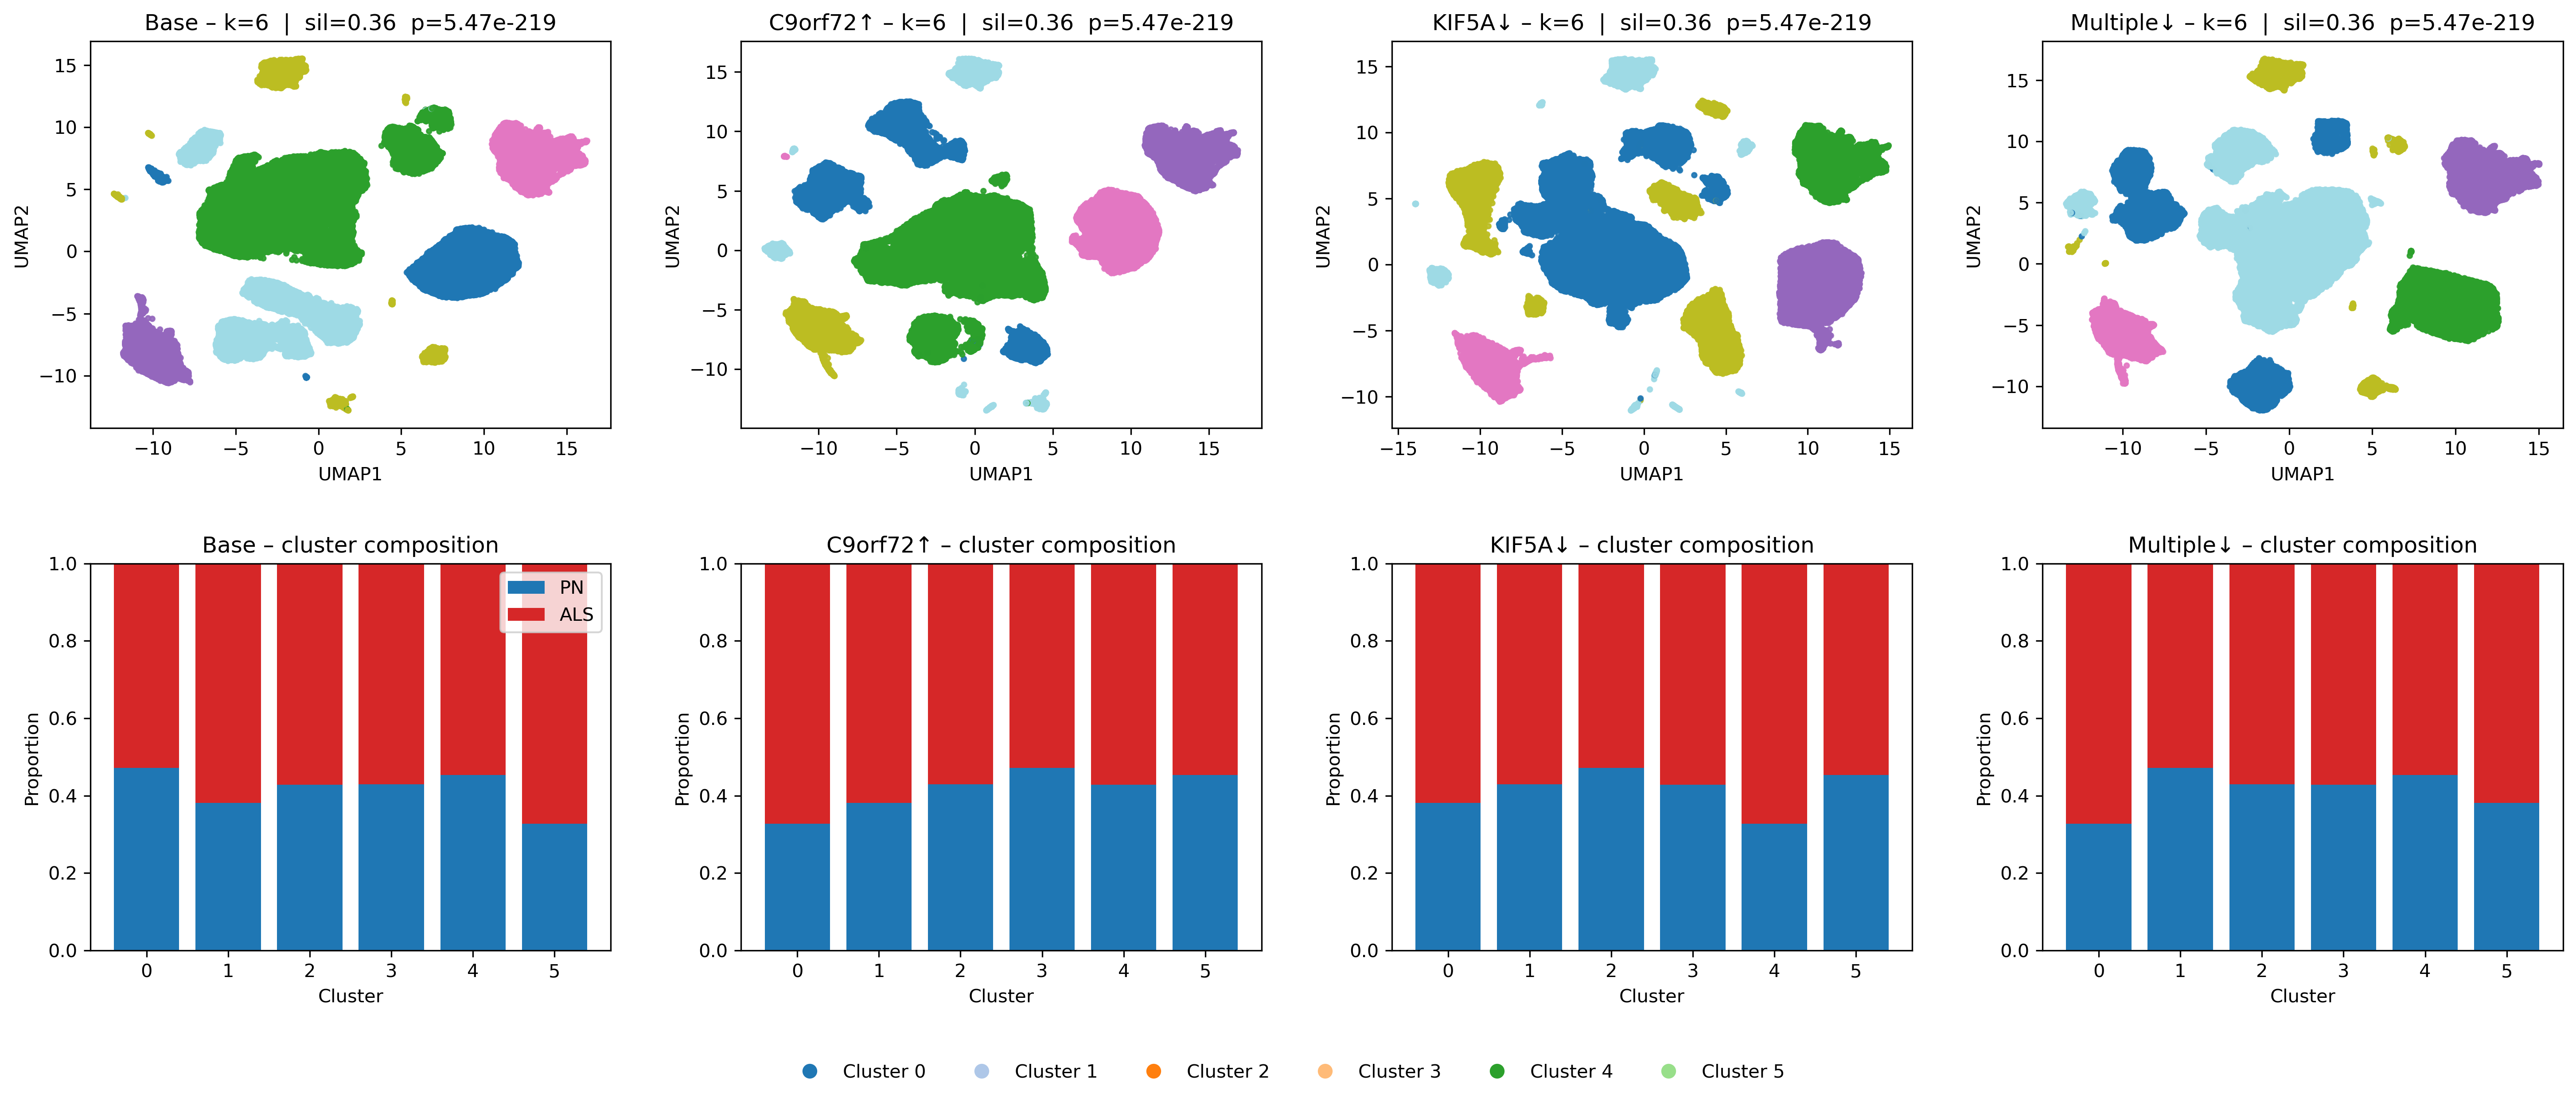

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
from matplotlib.lines import Line2D

k = 6
names  = ["Base","C9orf72↑","KIF5A↓","Multiple↓"]
embeds = [E_base, E_c9_als_up, E_k5_als_down, E_multiple_down]
adatas = [base,  C9orf72_als_up, KIF5A_als_down, multiple_als_down]
conds  = [norm_condition_df(a.obs) for a in adatas]

results = []
for name, E, a, c in zip(names, embeds, adatas, conds):
    km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(E)
    lab = km.labels_.astype(int)
    a.obs["k6"] = pd.Categorical(lab)
    U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0).fit_transform(E)
    sil = silhouette_score(E, lab, metric="euclidean")
    tab = pd.crosstab(a.obs["k6"], c)
    for col in ["als","pn"]:
        if col not in tab.columns:
            tab[col] = 0
    tab = tab[["pn","als"]].sort_index()
    chi2, p, dof, exp = chi2_contingency(tab.values) if tab.values.sum() > 0 else (np.nan, np.nan, np.nan, None)
    prop = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    tab.to_csv(f"{name}_k{k}_cluster_condition_counts.csv")
    prop.to_csv(f"{name}_k{k}_cluster_condition_props.csv")
    results.append((name, U, lab, prop, sil, p))

cmap = plt.colormaps.get_cmap("tab20")
n = len(results)
fig, axes = plt.subplots(2, n, figsize=(6*n, 9), constrained_layout=False)
if n == 1:
    axes = np.array([[axes[0]], [axes[1]]])

for i, (name, U, lab, prop, sil, p) in enumerate(results):
    ax = axes[0, i]
    ax.scatter(U[:,0], U[:,1], c=lab, s=6, cmap=cmap, vmin=0, vmax=k-1, alpha=0.9, rasterized=True)
    ax.set_title(f"{name} – k={k}  |  sil={sil:.2f}  p={p:.2e}")
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

for i, (name, U, lab, prop, sil, p) in enumerate(results):
    ax = axes[1, i]
    x = np.arange(prop.shape[0])
    ax.bar(x, prop["pn"].values, label="PN", color="#1f77b4")
    ax.bar(x, prop["als"].values, bottom=prop["pn"].values, label="ALS", color="#d62728")
    ax.set_xticks(x)
    ax.set_xticklabels([str(k_) for k_ in range(prop.shape[0])])
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cluster"); ax.set_ylabel("Proportion")
    ax.set_title(f"{name} – cluster composition")
    if i == 0:
        ax.legend()

handles = [Line2D([0], [0], marker="o", linestyle="None", markersize=8,
                  markerfacecolor=cmap(i % cmap.N), markeredgecolor="none", label=f"Cluster {i}")
           for i in range(k)]
fig.subplots_adjust(bottom=0.12, top=0.88, wspace=0.25, hspace=0.35)
fig.legend(handles=handles, loc="lower center", ncol=min(k,10), frameon=False)

plt.savefig(f"k{k}_umap_clusters_and_compositions_4panels.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig(f"k{k}_umap_clusters_and_compositions_4panels.pdf", bbox_inches="tight", facecolor="white")
plt.show()

**Figure 3B**: This figure shows us that the between different clusters, the proportions of `ALS` to `PN` cells is significantly different. Hence, it suggests that some cell types are disproportionately affected by `ALS`.

## 3.4. Neighborhood Analysis

We are using mean as the centroids because they minimize the sum squared distances in Euclidean geometry. 

- `fisher_ratio`: We calculate Fisher's ratio to find out if the groups got better clustered after perturbation (uses the principles of linear discriminant analysis to maximize between class variance and minimize within class variance). 
- `neighbor_label_fraction`: Here I am calculating what fraction of an ALS cell's neighborhood (15 cells) is PN cells. If the difference in the proportions was positive after perturbation, that would suggest that ALS cells mix more with PN cells which likely means that the prturbation is taking us towards a healthier cell state. 
- `median_projection_along_base_axis`: This function was a pretty simple way to check if the `ALS` cells moved towards `PN` cells. All I did was calculate a vector between the centroids of `ALS` and `PN` cells in the base data. And then I projected (dot product) the difference in the embeddings of the perturbation and the base onto that ALS-PN vector. A positive value should mean that we are moving towards `PN`. 



       group  fisher_ratio_base  fisher_ratio_pert  fisher_ratio_delta  \
0   C9orf72↑           0.012013           0.012114            0.000101   
1     KIF5A↓           0.012013           0.012020            0.000007   
2  Multiple↓           0.012013           0.012020            0.000008   

   als_neighbor_pn_frac_base  als_neighbor_pn_frac_pert  \
0                   0.169433                   0.169289   
1                   0.169433                   0.169483   
2                   0.169433                   0.167710   

   als_neighbor_pn_frac_delta  median_proj_ALS_along_base_axis  
0                   -0.000144                         0.000000  
1                    0.000050                         0.000000  
2                   -0.001723                         0.000727  


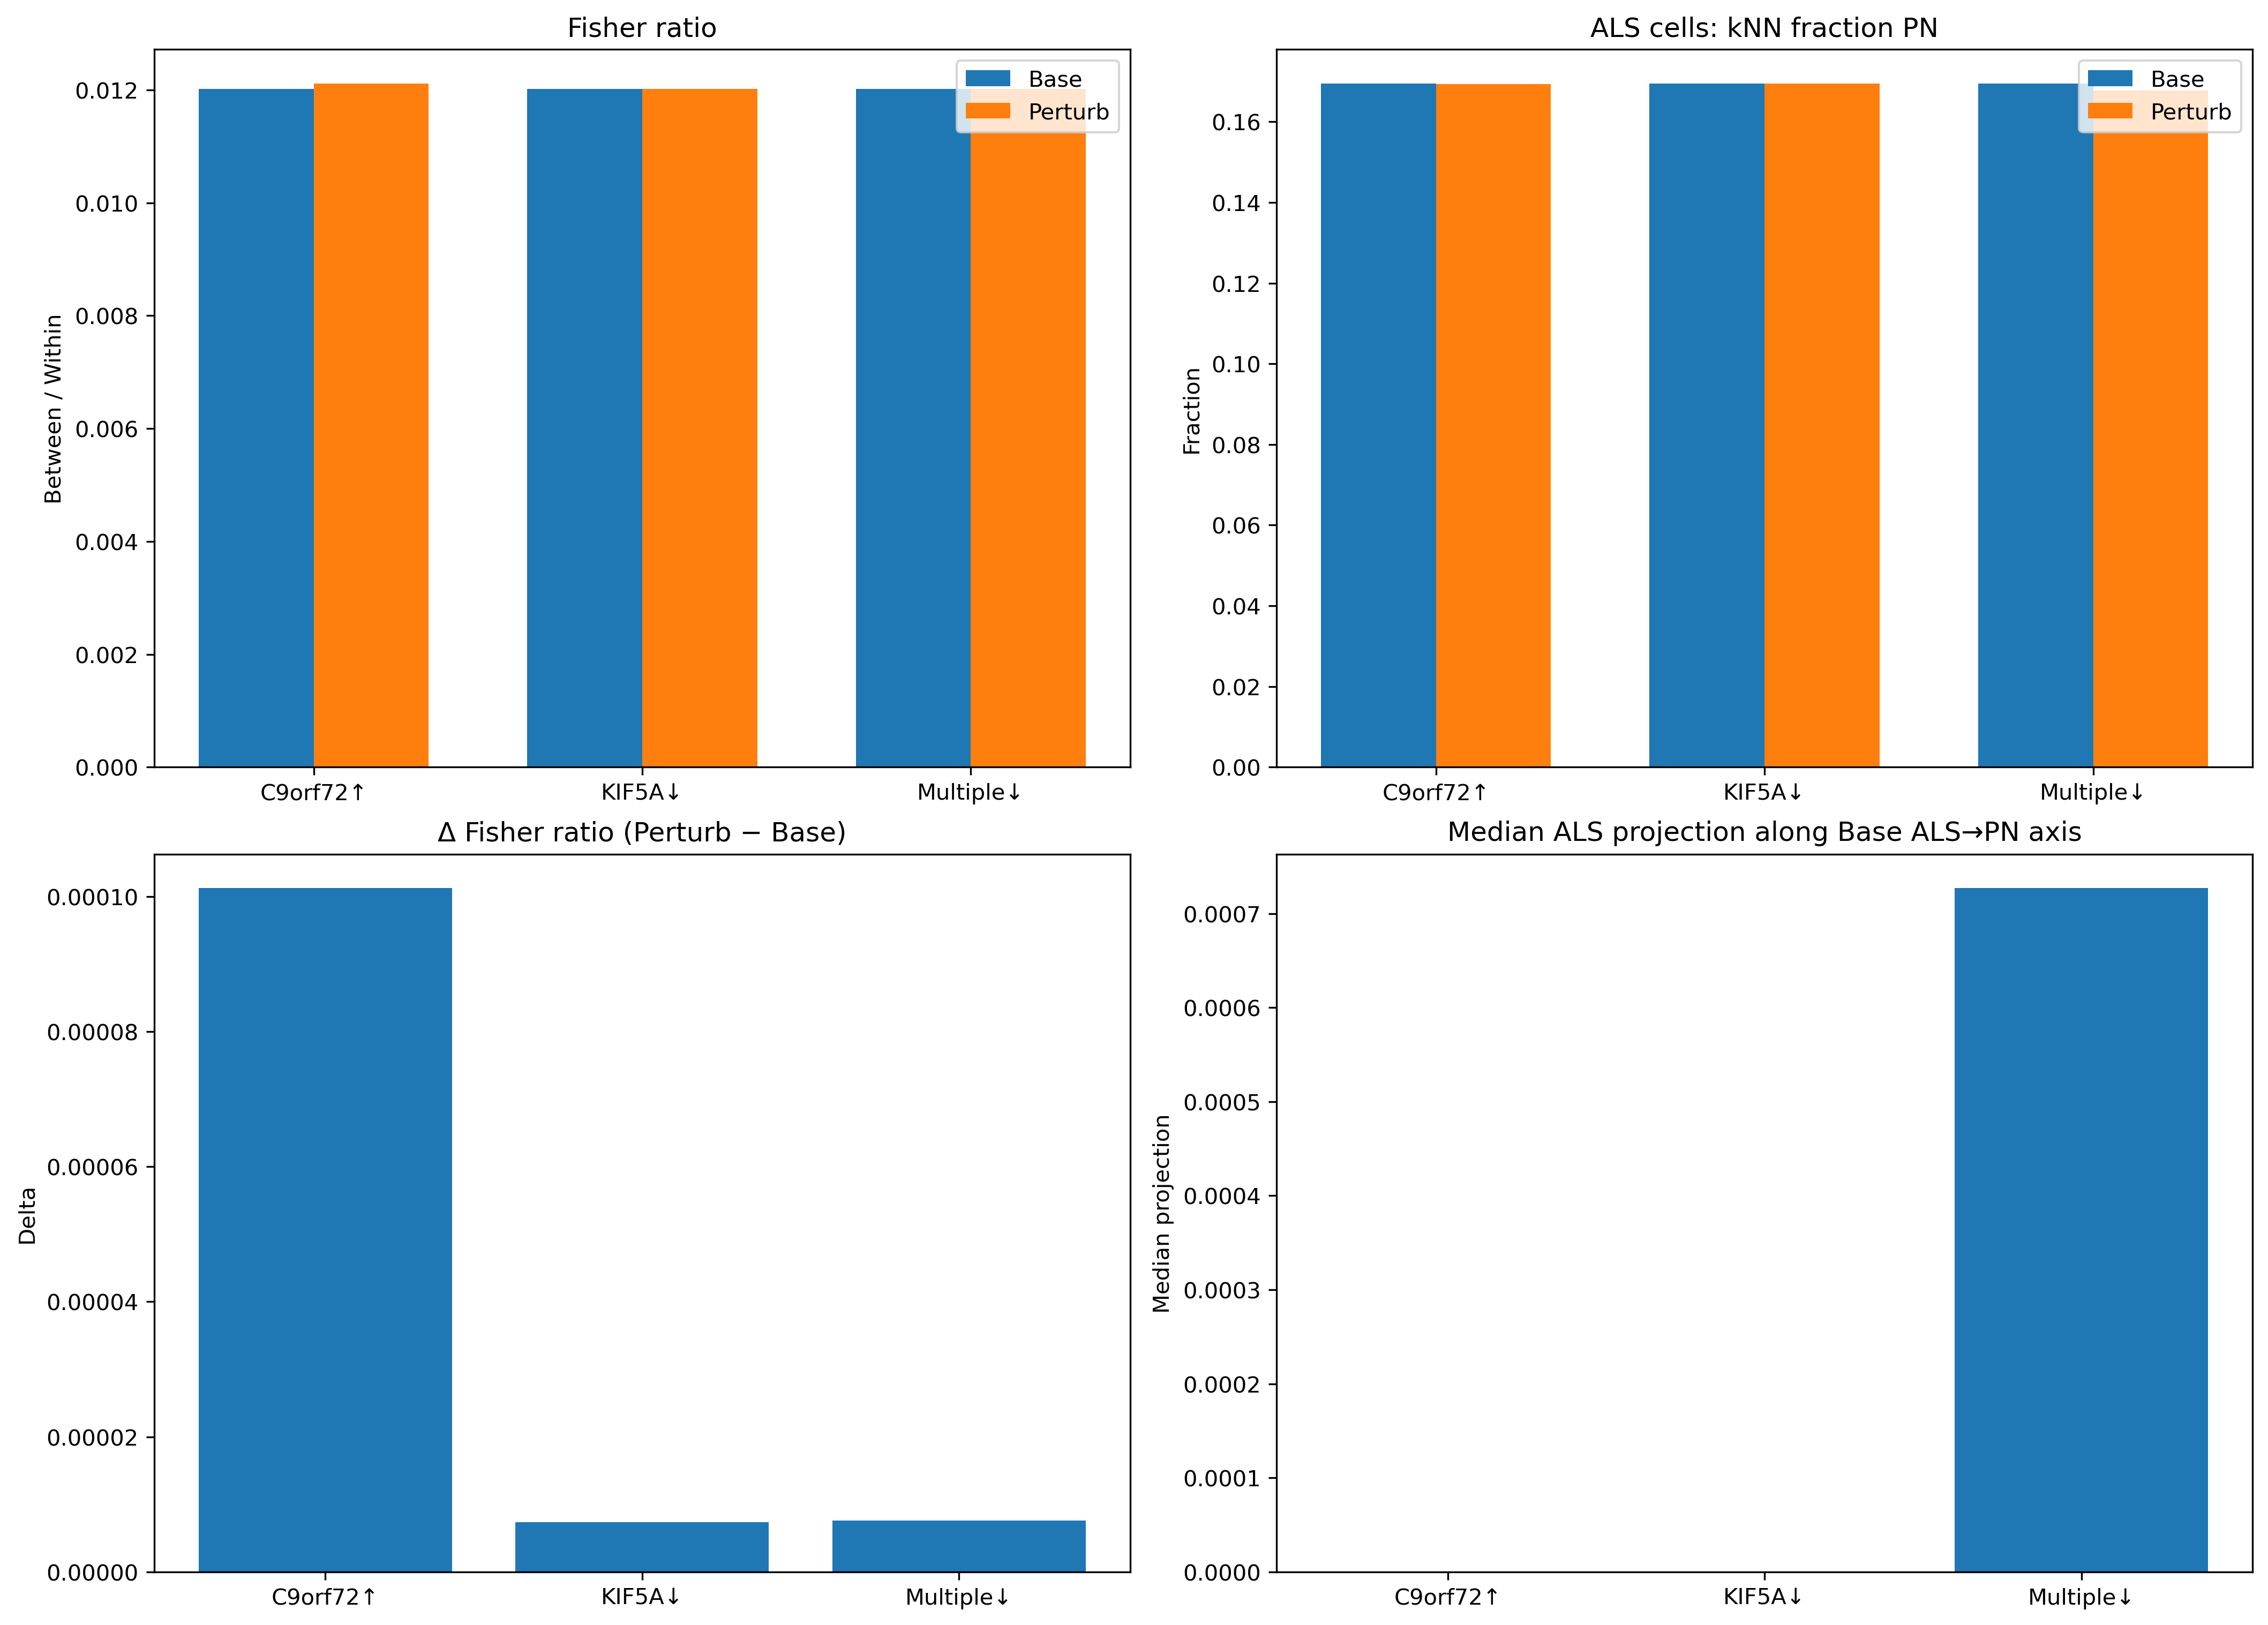

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def align_on_obs(base_adata, pert_adata, E_base, E_pert):
    common = base_adata.obs_names.intersection(pert_adata.obs_names)
    bi = base_adata.obs_names.get_indexer(common)
    pi = pert_adata.obs_names.get_indexer(common)
    return E_base[bi], E_pert[pi], base_adata.obs.loc[common]

def centroid(X):
    return np.nanmean(X, axis=0)

def fisher_ratio(E, labels):
    m_als = labels.values == "als"
    m_pn  = labels.values == "pn"
    if not m_als.any() or not m_pn.any():
        return np.nan
    c_als = centroid(E[m_als]); c_pn = centroid(E[m_pn])
    between = np.linalg.norm(c_als - c_pn)**2
    s_als = np.mean(np.sum((E[m_als] - c_als)**2, axis=1))
    s_pn  = np.mean(np.sum((E[m_pn]  - c_pn )**2, axis=1))
    within = s_als + s_pn + 1e-12
    return float(between / within)

def neighbor_label_fraction(E, labels, focus="als", target="pn", k=15):
    m_focus = labels.values == focus
    if not m_focus.any():
        return np.nan
    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(E)
    _, idx = nn.kneighbors(E[m_focus])
    idx = idx[:, 1:]
    lab_arr = labels.values
    targ = (lab_arr[idx] == target).mean(axis=1)
    return float(np.mean(targ))

def median_projection_along_base_axis(Eb, Ep, labels):
    m_als = labels.values == "als"; m_pn = labels.values == "pn"
    if not m_als.any() or not m_pn.any():
        return np.nan
    c_als_b = centroid(Eb[m_als]); c_pn_b = centroid(Eb[m_pn])
    u = c_pn_b - c_als_b
    u = u / (np.linalg.norm(u) + 1e-12)
    disp = Ep - Eb
    proj = disp[m_als] @ u
    return float(np.median(proj))

def compute_metrics_for(name, pert_adata, E_pert, base_adata, E_base):
    Eb_al, Ep_al, obs_b = align_on_obs(base_adata, pert_adata, E_base, E_pert)
    labs = norm_condition_df(obs_b)
    fr_base = fisher_ratio(Eb_al, labs)
    fr_pert = fisher_ratio(Ep_al, labs)
    mix_base = neighbor_label_fraction(Eb_al, labs, focus="als", target="pn", k=15)
    mix_pert = neighbor_label_fraction(Ep_al, labs, focus="als", target="pn", k=15)
    fr_delta = fr_pert - fr_base
    mix_delta = mix_pert - mix_base if not np.isnan(mix_base) and not np.isnan(mix_pert) else np.nan
    med_proj = median_projection_along_base_axis(Eb_al, Ep_al, labs)
    return {
        "group": name,
        "fisher_ratio_base": fr_base,
        "fisher_ratio_pert": fr_pert,
        "fisher_ratio_delta": fr_delta,
        "als_neighbor_pn_frac_base": mix_base,
        "als_neighbor_pn_frac_pert": mix_pert,
        "als_neighbor_pn_frac_delta": mix_delta,
        "median_proj_ALS_along_base_axis": med_proj,
    }

rows = []
rows.append(compute_metrics_for("C9orf72↑", C9orf72_als_up, E_c9_als_up, base, E_base))
rows.append(compute_metrics_for("KIF5A↓",   KIF5A_als_down, E_k5_als_down, base, E_base))
rows.append(compute_metrics_for("Multiple↓", multiple_als_down, E_multiple_down, base, E_base))

metrics2 = pd.DataFrame(rows)
metrics2.to_csv("extra_embedding_change_metrics_all.csv", index=False)
print(metrics2)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

x = np.arange(len(metrics2["group"]))
w = 0.35

axes[0,0].bar(x - w/2, metrics2["fisher_ratio_base"], width=w, label="Base")
axes[0,0].bar(x + w/2, metrics2["fisher_ratio_pert"], width=w, label="Perturb")
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(metrics2["group"])
axes[0,0].set_title("Fisher ratio")
axes[0,0].set_ylabel("Between / Within")
axes[0,0].legend()

axes[0,1].bar(x - w/2, metrics2["als_neighbor_pn_frac_base"], width=w, label="Base")
axes[0,1].bar(x + w/2, metrics2["als_neighbor_pn_frac_pert"], width=w, label="Perturb")
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(metrics2["group"])
axes[0,1].set_title("ALS cells: kNN fraction PN")
axes[0,1].set_ylabel("Fraction")
axes[0,1].legend()

axes[1,0].bar(x, metrics2["fisher_ratio_delta"])
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics2["group"])
axes[1,0].set_title("Δ Fisher ratio (Perturb − Base)")
axes[1,0].set_ylabel("Delta")

axes[1,1].bar(x, metrics2["median_proj_ALS_along_base_axis"])
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics2["group"])
axes[1,1].set_title("Median ALS projection along Base ALS→PN axis")
axes[1,1].set_ylabel("Median projection")

plt.savefig("metrics2_plots.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig("metrics2_plots.pdf", bbox_inches="tight", facecolor="white")
plt.show()

**Figure 4**: We can see that the difference in Fisher's ratio is positive for all the perturbations. However, it's more positive for C9orf72↑, which suggests that it might be making the `ALS` cells more `ALS`-like. Additionally, we see that in the distance moved across the projection of ALS-PN centroids, only multiple perturbations offer us a positive projection. This suggests that perturbing multiple genes at once likely moves the `ALS` cells to a more `PN`-like state. 

## 3.5. Simple MLP to Predict Condition from Embeddings

### 3.5.1. Helper Functions

This was perhaps not required, but I thought a great way to determine whether our perturbations had any effect would be to build a model that learns which embeddings come from `ALS` cells and which ones come from `PN` cells. I got this idea when I saw that there was a `split` column in the `.obs` and it had `test` and `train` split already defined. So I figured that this would be a great use of a pre-defined split. Therefore, I built a simple multi-layer perceptron (MLP) and trained it to predict `ALS` or `PN` based on the embeddings. 

Here's what the custom functions are doing:

- `pick_condition_series`: finds the `Condition` column and normalized PN. 
- `ensure_split_series`: gets use the split type (train or test)
- `align_on_common_obs`: just a little quality check to ensure that all the cells are aligned in the same order across the datasets and the embeddings. 
- `make_weighted_sampler`: sampling based on the proportions of the ALS and PN cells. 
- `plot_confmat`: simple function to plot a confusion matrix. 
- `best_threshold`: function for calculating the area under the ROC. 
- `infer_probs`: converts logits to probabilities

In [9]:
# -------------- Helpers --------------
def pick_condition_series(obs_df):
    # normalize Condition/condition to "als"/"pn"
    if "Condition" in obs_df.columns:
        s = obs_df["Condition"].astype(str)
    elif "condition" in obs_df.columns:
        s = obs_df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found in base.obs")
    s = s.str.strip().str.lower().replace({"np": "pn", "control": "pn"})
    return s

def ensure_split_series(obs_df):
    if "split" not in obs_df.columns:
        raise KeyError("base.obs['split'] not found (expected 'train'/'test').")
    s = obs_df["split"].astype(str).str.strip().str.lower()
    return s

def align_on_common_obs(base_ad, pert_ad, E_base, E_pert, subset_index=None):
    """
    Align rows by shared obs_names; if subset_index is given (positional indices into base),
    restrict to those base rows first. Returns:
      Eb_aligned, Ep_aligned, common_names (Index), base_pos_idx (np.ndarray of ints)
    """
    if subset_index is not None:
        base_subset_names = base_ad.obs_names[subset_index]
        common = base_subset_names.intersection(pert_ad.obs_names)
    else:
        common = base_ad.obs_names.intersection(pert_ad.obs_names)
    if len(common) == 0:
        raise ValueError("No overlapping cells between base and pert for the given subset.")
    b_idx = base_ad.obs_names.get_indexer(common)
    p_idx = pert_ad.obs_names.get_indexer(common)
    return E_base[b_idx], E_pert[p_idx], common, b_idx

def make_weighted_sampler(y_int):
    class_counts = np.bincount(y_int, minlength=2)
    class_counts = np.maximum(class_counts, 1)
    weights = 1.0 / class_counts
    sample_weights = weights[y_int]
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

def plot_confmat(cm, labels, title, outfile=None):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_xticklabels(labels)
    ax.set_yticks([0,1]); ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(int(cm[i, j])), ha="center", va="center",
                    color=("white" if cm[i, j] > cm.max()/2 else "black"), fontsize=10)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()

def train_with_scheduler(
    model, train_dl, val_X_t, val_y_np, pos_weight, device,
    base_lr=1e-3, weight_decay=1e-4, epochs=40, patience=8
):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    optim = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

    steps_per_epoch = max(len(train_dl), 1)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optim, max_lr=base_lr, steps_per_epoch=steps_per_epoch, epochs=epochs
    )

    best_state, best_auroc, wait = None, -np.inf, 0
    sigmoid = nn.Sigmoid()

    def eval_auroc(X_t, y_true_np):
        model.eval()
        probs = []
        with torch.no_grad():
            for i in range(0, X_t.shape[0], 2048):
                xb = X_t[i:i+2048].to(device)
                logits = model(xb)
                probs.append(sigmoid(logits).cpu().numpy())
        probs = np.concatenate(probs)
        if len(np.unique(y_true_np)) < 2:
            return np.nan, probs
        return roc_auc_score(y_true_np, probs), probs

    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb, yb in train_dl:
            xb = xb.to(device); yb = yb.to(device)
            optim.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            sched.step()
            running += loss.item() * xb.size(0)

        val_auroc, _ = eval_auroc(val_X_t, val_y_np)
        print(f"Epoch {epoch:03d} | train_loss {running/len(train_dl.dataset):.4f} | val_AUROC {val_auroc:.4f}")

        improved = np.isfinite(val_auroc) and (val_auroc > best_auroc + 1e-4)
        if improved:
            best_auroc = val_auroc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping on AUROC.")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model

def best_threshold(y_true, y_prob, metric="youden"):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    if metric == "youden":
        j = tpr - fpr
        return float(thr[np.argmax(j)])
    return 0.5

def infer_probs(model, X_np, device):
    model.eval()
    X_t = torch.from_numpy(X_np).float().to(device)
    probs = []
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        for i in range(0, X_t.shape[0], 2048):
            xb = X_t[i:i+2048]
            logits = model(xb)
            probs.append(sigmoid(logits).cpu().numpy())
    return np.concatenate(probs)

def get_celltype_series(obs, keys=("CellType","Celltype","cell_type","CellClass")):
    for k in keys:
        if k in obs.columns:
            return obs[k].astype(str).fillna("Unknown"), k
    raise KeyError(f"No cell-type column found (tried: {', '.join(keys)})")

def ci95(x):
    return np.percentile(x, [2.5, 97.5])

This is a simple MLP, with the following architecture:
- 3 hidden layers
- Batch normalization on every hidden layer
- 20% Dropout by default
- Relu activation function

In [10]:
class MLP_GELU_BN(nn.Module):
    def __init__(self, d_in, hidden=(256, 128, 64), p_drop=0.2):
        super().__init__()
        self.in_norm = nn.LayerNorm(d_in)
        self.fc1 = nn.Linear(d_in, hidden[0]); self.bn1 = nn.BatchNorm1d(hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1]); self.bn2 = nn.BatchNorm1d(hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2]); self.bn3 = nn.BatchNorm1d(hidden[2])
        self.out = nn.Linear(hidden[2], 1)
        self.drop = nn.Dropout(p_drop)

        for m in [self.fc1, self.fc2, self.fc3, self.out]:
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.in_norm(x)
        x = self.drop(F.gelu(self.bn1(self.fc1(x))))
        x = self.drop(F.gelu(self.bn2(self.fc2(x))))
        x = self.drop(F.gelu(self.bn3(self.fc3(x))))
        return self.out(x).squeeze(1)  # logits

Epoch 001 | train_loss 0.6235 | val_AUROC 0.6005
Epoch 002 | train_loss 0.5758 | val_AUROC 0.7047
Epoch 003 | train_loss 0.5373 | val_AUROC 0.7692
Epoch 004 | train_loss 0.5070 | val_AUROC 0.8113
Epoch 005 | train_loss 0.4735 | val_AUROC 0.8406
Epoch 006 | train_loss 0.4465 | val_AUROC 0.8636
Epoch 007 | train_loss 0.4215 | val_AUROC 0.8810
Epoch 008 | train_loss 0.3916 | val_AUROC 0.8962
Epoch 009 | train_loss 0.3662 | val_AUROC 0.9085
Epoch 010 | train_loss 0.3432 | val_AUROC 0.9191
Epoch 011 | train_loss 0.3221 | val_AUROC 0.9276
Epoch 012 | train_loss 0.3011 | val_AUROC 0.9363
Epoch 013 | train_loss 0.2870 | val_AUROC 0.9415
Epoch 014 | train_loss 0.2726 | val_AUROC 0.9457
Epoch 015 | train_loss 0.2582 | val_AUROC 0.9504
Epoch 016 | train_loss 0.2482 | val_AUROC 0.9535
Epoch 017 | train_loss 0.2392 | val_AUROC 0.9570
Epoch 018 | train_loss 0.2284 | val_AUROC 0.9599
Epoch 019 | train_loss 0.2192 | val_AUROC 0.9623
Epoch 020 | train_loss 0.2144 | val_AUROC 0.9639
Epoch 021 | train_lo

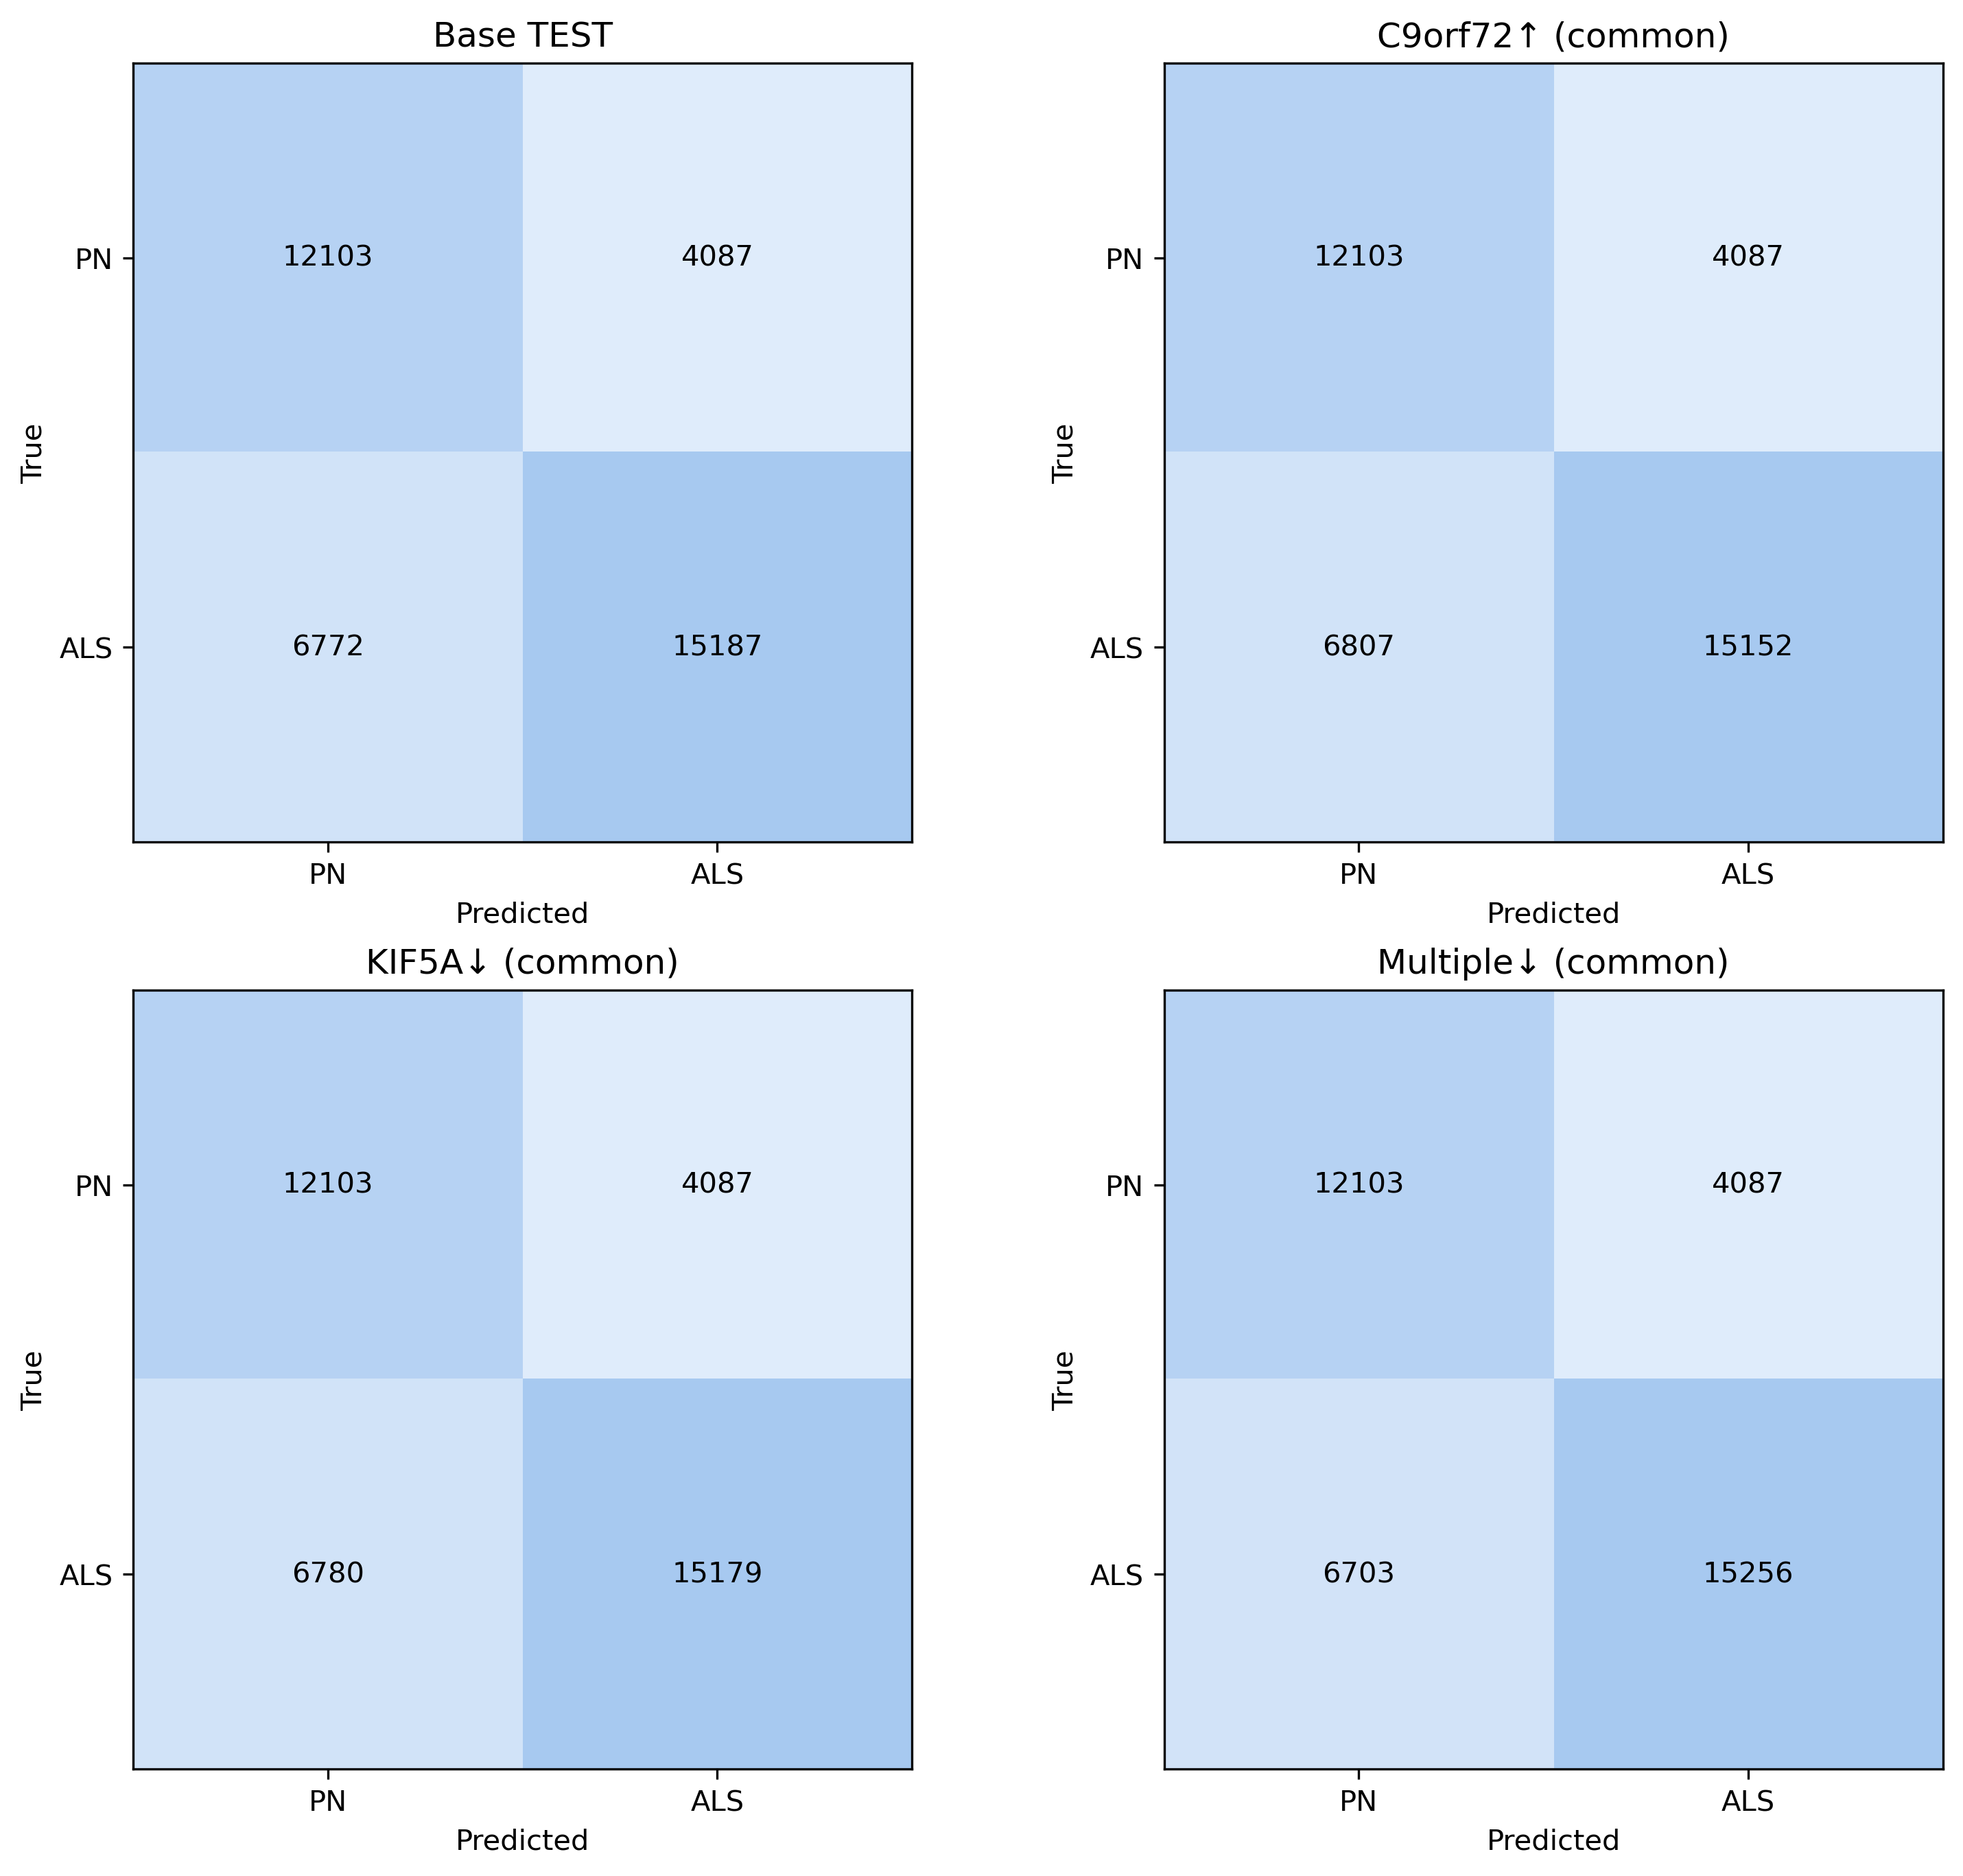

In [14]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

cond_series_full  = pick_condition_series(base.obs)
split_series_full = ensure_split_series(base.obs)
valid_mask_full = cond_series_full.isin(["pn", "als"])
y_all_full = (cond_series_full.values == "als").astype(np.int64)
idx_train_full = (split_series_full.values == "train") & valid_mask_full.values
idx_test_full  = (split_series_full.values == "test")  & valid_mask_full.values

X_train_full = E_base[idx_train_full, :]
y_train_full = y_all_full[idx_train_full]
X_test_base  = E_base[idx_test_full, :]
y_test       = y_all_full[idx_test_full]

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=0, stratify=y_train_full
)

X_tr_t = torch.from_numpy(X_tr).float()
y_tr_t = torch.from_numpy(y_tr.astype(np.float32))
train_ds = torch.utils.data.TensorDataset(X_tr_t, y_tr_t)
sampler = make_weighted_sampler(y_tr.astype(int))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, sampler=sampler, drop_last=False)

val_X_t = torch.from_numpy(X_val).float()

d_in = X_tr.shape[1]
model = MLP_GELU_BN(d_in, hidden=(256,128,64), p_drop=0.2)

pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
pos_weight = torch.tensor([(neg / max(pos,1))], dtype=torch.float32)

model = train_with_scheduler(
    model, train_dl, val_X_t, y_val, pos_weight, device=device,
    base_lr=1e-4, weight_decay=1e-4, epochs=100, patience=8
)

thr = 0.5

test_probs_base = infer_probs(model, X_test_base, device)
y_pred_base = (test_probs_base >= thr).astype(int)
acc_base = accuracy_score(y_test, y_pred_base)
auroc_base = roc_auc_score(y_test, test_probs_base) if len(np.unique(y_test))==2 else np.nan
cm_base = confusion_matrix(y_test, y_pred_base, labels=[0,1])

test_mask_full = (split_series_full.values == "test") & valid_mask_full.values
if test_mask_full.sum() == 0:
    raise ValueError("No cells in base test split after filtering PN/ALS.")

def eval_on_pert(pert_name, pert_adata, E_pert):
    Eb_comm, Ep_comm, common_names, base_pos_idx = align_on_common_obs(
        base, pert_adata, E_base, E_pert, subset_index=np.where(test_mask_full)[0]
    )
    y_comm = y_all_full[base_pos_idx]
    probs_p = infer_probs(model, Ep_comm, device)
    pred_p = (probs_p >= thr).astype(int)
    cm_p = confusion_matrix(y_comm, pred_p, labels=[0,1])
    acc_p = accuracy_score(y_comm, pred_p)
    auroc_p = roc_auc_score(y_comm, probs_p) if len(np.unique(y_comm))==2 else np.nan
    return cm_p, acc_p, auroc_p, len(y_comm)

cm_c9,  acc_c9,  auroc_c9,  n_c9  = eval_on_pert("C9orf72↑", C9orf72_als_up, E_c9_als_up)
cm_kif, acc_kif, auroc_kif, n_kif = eval_on_pert("KIF5A↓",   KIF5A_als_down, E_k5_als_down)
cm_mul, acc_mul, auroc_mul, n_mul = eval_on_pert("Multiple↓", multiple_als_down, E_multiple_down)

summary = pd.DataFrame([
    {"group":"Base (all test)",     "n":X_test_base.shape[0], "acc":acc_base, "auroc":auroc_base},
    {"group":"C9orf72↑ (common)",   "n":n_c9,  "acc":acc_c9,  "auroc":auroc_c9},
    {"group":"KIF5A↓ (common)",     "n":n_kif, "acc":acc_kif, "auroc":auroc_kif},
    {"group":"Multiple↓ (common)",  "n":n_mul, "acc":acc_mul, "auroc":auroc_mul},
])
print(summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
summary.to_csv("clf_eval_summary_thr0.5.csv", index=False)

def plot_cm(ax, cm, title, vmax):
    light_blues = LinearSegmentedColormap.from_list("light_blues", ["#f4f9ff", "#a7c9f0"])
    im = ax.imshow(cm, cmap=light_blues, vmin=0, vmax=vmax)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center", fontsize=10)
    ax.set_xticks([0,1]); ax.set_xticklabels(["PN","ALS"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["PN","ALS"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(title)

vmax_all = max(cm_base.max(), cm_c9.max(), cm_kif.max(), cm_mul.max())

fig, axes = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)
plot_cm(axes[0,0], cm_base, "Base TEST", vmax_all)
plot_cm(axes[0,1], cm_c9,   "C9orf72↑ (common)", vmax_all)
plot_cm(axes[1,0], cm_kif,  "KIF5A↓ (common)", vmax_all)
plot_cm(axes[1,1], cm_mul,  "Multiple↓ (common)", vmax_all)
plt.savefig("confmats_2x2.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig("confmats_2x2.pdf", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

**Figure 5**: Based on the data, we see that when we run the trained model - which performs decently, given its AUROC of 0.79, and comparable accuracy of 0.71 - on the test cells in the perturbed data data, we get more cells as false negatives (predicted to be `PN`, but actually are `ALS`) in the _C9orf72_ and _KIF5A_ datasets. On the other hand, the numnber of cells reduce in the multiple-perturbed dataset. Therefore, it seems that the perturbation might have worked for the additional cells that were predicted to be `PN` but actually are `ALS`. But we need to put a p-value on this difference, so we will do that next by bootstrapping it 10,000 times. 

Device: mps
       group  n_common  FN_base_obs  FN_pert_obs  FN_diff_obs  FN_base_mean  \
0   C9orf72↑     38149         6772         6807           35     6770.9961   
1     KIF5A↓     38149         6772         6780            8     6770.9961   
2  Multiple↓     38149         6772         6703          -69     6770.9961   

   FN_pert_mean  FN_diff_mean  FN_base_ci_lo  FN_base_ci_hi  FN_pert_ci_lo  \
0     6806.1277       35.1316         6627.0         6918.0       6660.000   
1     6778.9248        7.9287         6627.0         6918.0       6634.000   
2     6702.1341      -68.8620         6627.0         6918.0       6557.975   

   FN_pert_ci_hi  FN_diff_ci_lo  FN_diff_ci_hi  p_two_sided  \
0         6955.0            6.0           65.0          1.0   
1         6928.0          -20.0           36.0          1.0   
2         6847.0         -119.0          -19.0          1.0   

   p_one_sided_diff_lt_0  
0               0.517148  
1               0.510449  
2               0.507449

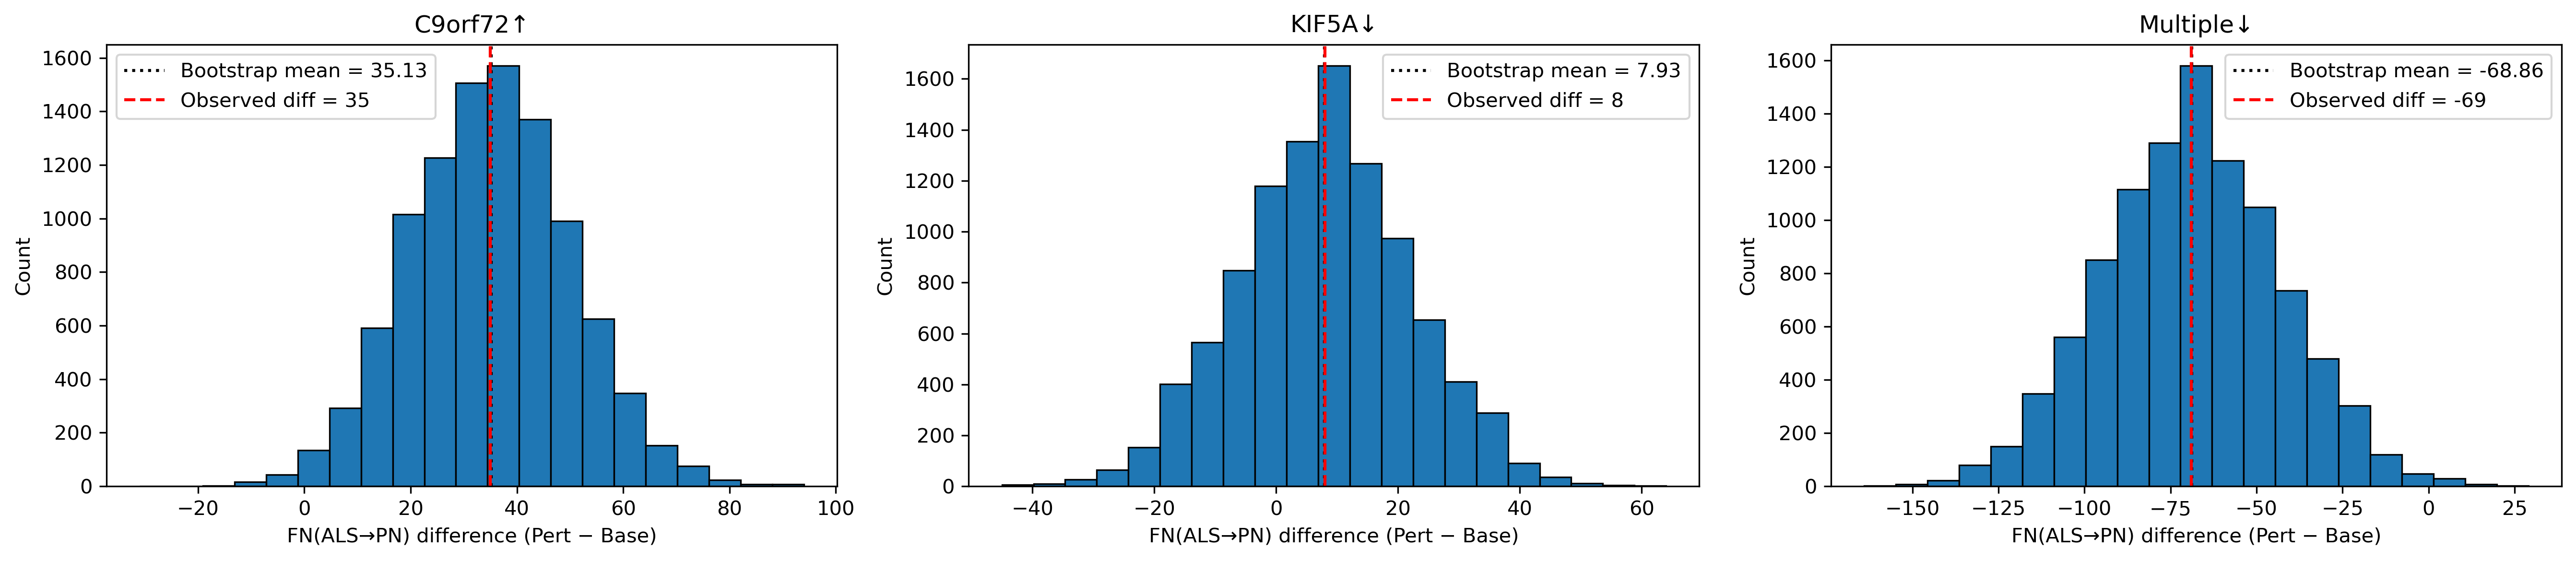

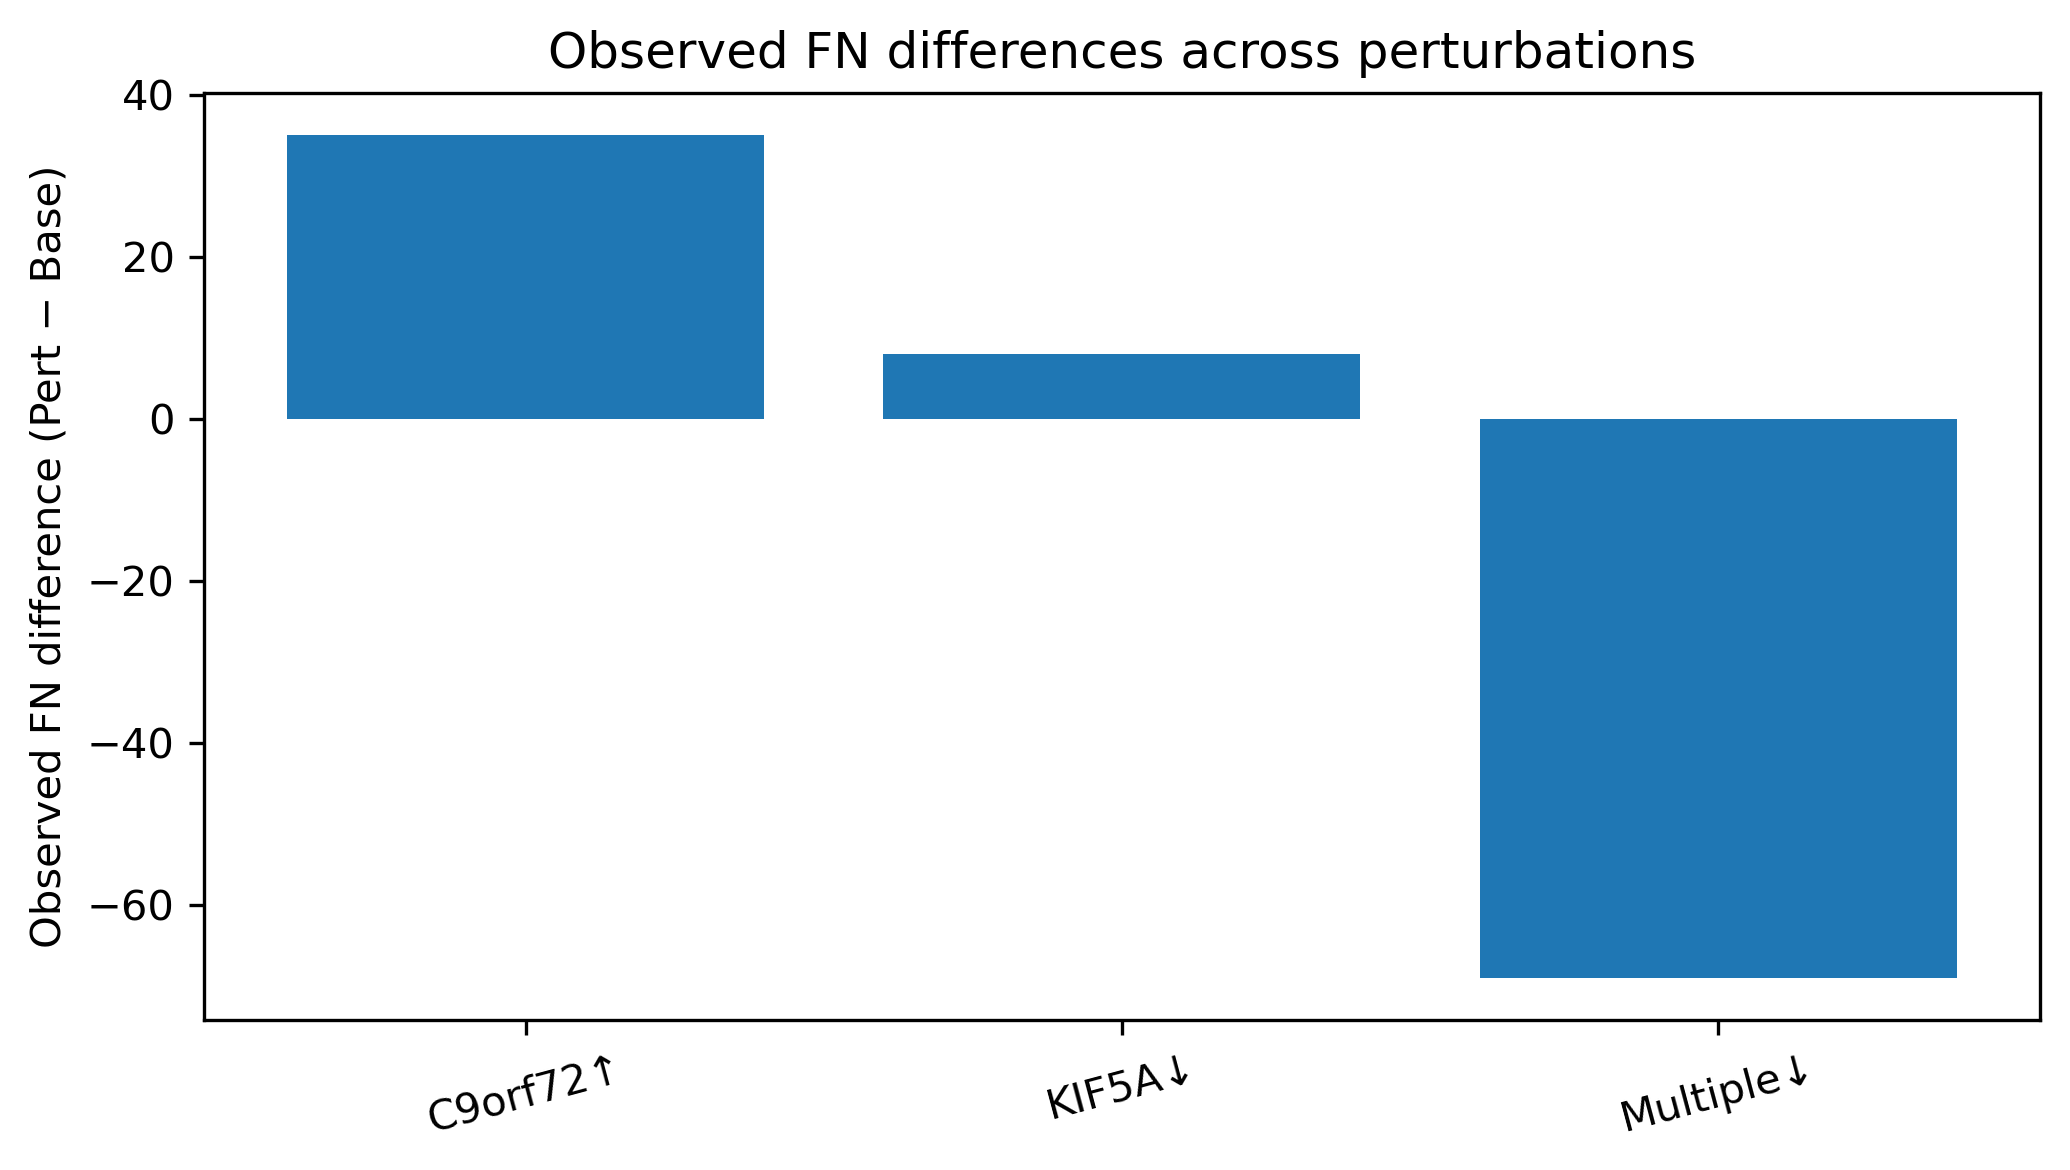

In [16]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def ci95(x):
    return np.percentile(x, [2.5, 97.5])

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if "model" not in globals():
    raise RuntimeError("Trained `model` not found in globals().")
if "thr" not in globals():
    print("Warning: decision threshold `thr` not found; defaulting to 0.5")
    thr = 0.5

cond_series = pick_condition_series(base.obs)
split_series = ensure_split_series(base.obs)
valid_mask = cond_series.isin(["pn", "als"])
y_all = (cond_series.values == "als").astype(int)

test_mask = (split_series.values == "test") & valid_mask.values
if test_mask.sum() == 0:
    raise ValueError("No PN/ALS cells in base test split.")

pert_list = [
    ("C9orf72↑", C9orf72_als_up, E_c9_als_up, "c9"),
    ("KIF5A↓",   KIF5A_als_down, E_k5_als_down, "kif5a"),
    ("Multiple↓", multiple_als_down, E_multiple_down, "multiple"),
]

rows = []
hists = []
for pname, pad, Ep, short in pert_list:
    Eb_test, Ep_test, common_names, base_pos_idx = align_on_common_obs(
        base, pad, E_base, Ep, subset_index=np.where(test_mask)[0]
    )
    y_test = y_all[base_pos_idx]
    N = len(y_test)

    probs_base = infer_probs(model, Eb_test, device=device)
    probs_pert = infer_probs(model, Ep_test, device=device)
    pred_base  = (probs_base >= thr).astype(int)
    pred_pert  = (probs_pert >= thr).astype(int)

    FN_base_obs = int(np.sum((y_test==1) & (pred_base==0)))
    FN_pert_obs = int(np.sum((y_test==1) & (pred_pert==0)))
    diff_obs    = FN_pert_obs - FN_base_obs

    B = 10000
    rng = np.random.default_rng(0)
    cms_base = np.zeros((B, 2, 2), dtype=int)
    cms_pert = np.zeros((B, 2, 2), dtype=int)
    FN_base_boot = np.zeros(B, dtype=int)
    FN_pert_boot = np.zeros(B, dtype=int)
    diff_boot    = np.zeros(B, dtype=int)

    for b in range(B):
        idx = rng.choice(N, size=N, replace=True)
        yb   = y_test[idx]
        pb_b = pred_base[idx]
        pb_p = pred_pert[idx]
        cms_base[b] = confusion_matrix(yb, pb_b, labels=[0,1])
        cms_pert[b] = confusion_matrix(yb, pb_p, labels=[0,1])
        FN_base_boot[b] = int(np.sum((yb==1) & (pb_b==0)))
        FN_pert_boot[b] = int(np.sum((yb==1) & (pb_p==0)))
        diff_boot[b]    = FN_pert_boot[b] - FN_base_boot[b]

    mean_base = FN_base_boot.mean()
    mean_pert = FN_pert_boot.mean()
    mean_diff = diff_boot.mean()
    ci_base   = ci95(FN_base_boot)
    ci_pert   = ci95(FN_pert_boot)
    ci_diff   = ci95(diff_boot)

    center = mean_diff
    t_obs  = abs(diff_obs - center)
    ts     = abs(diff_boot - center)
    p_two  = (np.sum(ts >= t_obs) + 1) / (B + 1)
    if diff_obs < 0:
        p_one = (np.sum(diff_boot <= diff_obs) + 1) / (B + 1)
    else:
        p_one = (np.sum(diff_boot >= diff_obs) + 1) / (B + 1)

    rows.append({
        "group": pname,
        "n_common": N,
        "FN_base_obs": FN_base_obs,
        "FN_pert_obs": FN_pert_obs,
        "FN_diff_obs": diff_obs,
        "FN_base_mean": mean_base,
        "FN_pert_mean": mean_pert,
        "FN_diff_mean": mean_diff,
        "FN_base_ci_lo": ci_base[0], "FN_base_ci_hi": ci_base[1],
        "FN_pert_ci_lo": ci_pert[0], "FN_pert_ci_hi": ci_pert[1],
        "FN_diff_ci_lo": ci_diff[0], "FN_diff_ci_hi": ci_diff[1],
        "p_two_sided": p_two,
        "p_one_sided_diff_lt_0": p_one
    })

    np.savez_compressed(
        f"bootstrap_confmats_base_{short}.npz",
        cms_base=cms_base, cms_pert=cms_pert,
        FN_base_boot=FN_base_boot, FN_pert_boot=FN_pert_boot, diff_boot=diff_boot,
        FN_base_obs=FN_base_obs, FN_pert_obs=FN_pert_obs, diff_obs=diff_obs
    )
    hists.append((pname, diff_boot, mean_diff, diff_obs))

summary = pd.DataFrame(rows)
summary.to_csv("bootstrap_FN_diff_summary.csv", index=False)
print(summary)

cols = len(hists)
plt.figure(figsize=(6*cols, 4))
for i, (pname, diff_boot, mean_diff, diff_obs) in enumerate(hists, 1):
    plt.subplot(1, cols, i)
    plt.hist(diff_boot, bins=21, edgecolor="black", linewidth=0.8)
    plt.axvline(mean_diff, color="k", linestyle=":", label=f"Bootstrap mean = {mean_diff:.2f}")
    plt.axvline(diff_obs, color="red", linestyle="--", label=f"Observed diff = {diff_obs}")
    plt.xlabel("FN(ALS→PN) difference (Pert − Base)")
    plt.ylabel("Count")
    plt.title(pname)
    plt.legend()
plt.tight_layout()
plt.savefig("bootstrap_FN_diff_hists.png", bbox_inches="tight")
plt.savefig("bootstrap_FN_diff_hists.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(7,4))
x = np.arange(len(summary))
plt.bar(x, summary["FN_diff_obs"])
plt.xticks(x, summary["group"], rotation=15)
plt.ylabel("Observed FN difference (Pert − Base)")
plt.title("Observed FN differences across perturbations")
plt.tight_layout()
plt.savefig("bootstrap_FN_diff_bars.png", bbox_inches="tight")
plt.savefig("bootstrap_FN_diff_bars.pdf", bbox_inches="tight")
plt.show()

**Figure 6**: Based on the 10,000 bootstraps, we see that the difference of cells comes very close to the bootstrap means across all perturbations. This means that our difference is not statistically significant, and that we can conclude that based on this preliminary analysis, increasing the expression of _C9orf72_ 4-folds, or decreaseing _KIF5A_ or multiple genes 4-folds does not seem to help in shifting the disease state of ALS cells. Perhaps perturbing any of the remaining 42 genes might have more drastic changes, but that is limited by the access to GPU resources. 